<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Feature Engineering </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (feature) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook](https://www.kaggle.com/code/rogeriodelfim/tps-nov-2022-01-eda-baseline), para isso vamos os seguintes passos: 

- Criar marcações levando em consideração a EDA realizada;
- Nova features estatísticas (sum, mean, etc);
- Feature de PCA; 
- Clusterização;
- Acrescentar as previsões geradas no notebook anterior ao dataset.

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb
    !pip install --q eli5
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import multiprocessing
import glob
import pickle
import scipy.optimize 
import scipy.special

In [3]:
import pandas                    as pd
import numpy                     as np
import matplotlib.pyplot         as plt 
import seaborn                   as sns
import joblib                    as jb
import scipy.stats               as stats
import plotly.express            as px
import xgboost                   as xgb
import lightgbm                  as lgb
import scikitplot                as skplt
import sklearn.feature_selection as fs
import category_encoders         as ce
import tensorflow                as tf

In [4]:
from matplotlib.axes._axes     import _log as matplotlib_axes_logger
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing     import StandardScaler,  OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.metrics           import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics           import classification_report, confusion_matrix
from scipy.stats               import spearmanr
from sklearn.impute            import SimpleImputer

In [5]:
from sklearn                    import set_config 
from sklearn.utils              import estimator_html_repr 
from IPython.core.display       import HTML , display_html 
from imblearn.pipeline          import Pipeline
from sklearn.compose            import ColumnTransformer, make_column_transformer

In [6]:
from tqdm.notebook             import tqdm, trange
from datetime                  import datetime
from colorama                  import Fore, Back, Style
from sklearn.calibration       import CalibrationDisplay
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.feature_selection import RFECV, SelectFromModel
from eli5.sklearn              import PermutationImportance
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition     import PCA
from sklearn.mixture           import GaussianMixture, BayesianGaussianMixture
from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster           import KMeans, AgglomerativeClustering

In [7]:
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import ExtraTreesClassifier   
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.ensemble          import HistGradientBoostingClassifier
from sklearn.ensemble          import StackingClassifier

In [8]:
# Tensorflow
import wandb
import graphviz 
# import math
  
from sklearn.tree               import export_graphviz
from tensorflow                 import keras
from keras                      import backend as K
from tensorflow.keras           import layers, callbacks
from tensorflow.keras.utils     import plot_model
from wandb.keras                import WandbCallback
from sklearn.metrics            import log_loss, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau#, LearningRateScheduler, EarlyStopping

<p style="border-bottom: 2px solid #256B5D"/></p>

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [9]:
def plot_hist(hist):
    history_df = pd.DataFrame(hist.history)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'],label='Train')
    plt.plot(history_df['val_loss'],label='Valid')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history_df['auc'],label='Train')
    plt.plot(history_df['val_auc'],label='Valid')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [10]:
def create_model(input_shape_):

    tf.random.set_seed(seed)

    activation_layer = 'swish' #'relu' # 'swish' 
    input_shape      = input_shape_
    units            = int((input_shape))
    activation       = 'sigmoid' # mish  sigmoid
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
    # kernel_regularizer: Regularizador para aplicar uma penalidade no kernel da camada
    # bias_regularizer: Regularizador para aplicar uma penalidade no viés da camada
    # activity_regularizer: Regularizador para aplicar uma penalidade na saída da camada
    reg_1     = 1e-04 
    reg_2     = 1e-05
    activity_r = tf.keras.regularizers.L1L2(l1=1e-06, l2=1e-07)  # L1 + L2 penalties
    activity_r = tf.keras.regularizers.L1L2(l1=1e-04, l2=1e-05)  # L1 + L2 penalties
    
    model = keras.Sequential([    
        layers.BatchNormalization(input_shape=[input_shape] , activity_regularizer=activity_r), #
        layers.Dense(units, activation=activation_layer), 
        layers.BatchNormalization(),
        layers.Dropout(0.6), 
        layers.Dense(512, activation=activation_layer, activity_regularizer=activity_r ),    
        layers.Dropout(0.3),    
        layers.Dense(256, activation=activation_layer, activity_regularizer=activity_r),
        layers.Dropout(0.3),
        layers.Dense(128, activation=activation_layer),
        layers.Dropout(0.3),   
        layers.Dense(32, activation=activation_layer),        
        layers.Dropout(0.3),   
        layers.Dense(1, activation=activation)     
    ])
    
    model = keras.Sequential([    
        layers.BatchNormalization(input_shape=[input_shape]), 
        layers.Dense(units, activation=activation_layer, activity_regularizer=activity_r ),
        layers.BatchNormalization(),
        layers.Dropout(0.6), 
        layers.Dense(512, activation=activation_layer),    
        layers.Dropout(0.3),    
        layers.Dense(256, activation=activation_layer),
        layers.Dropout(0.3),
        layers.Dense(128, activation=activation_layer),
        layers.Dropout(0.3),
        #layers.Dense(64, activation=activation_layer),
        #layers.Dropout(0.4),   
        layers.Dense(32, activation=activation_layer),        
        layers.Dropout(0.3),   
        layers.Dense(1, activation=activation)     
    ])
    
    model.compile(loss      = tf.keras.losses.BinaryCrossentropy(),       
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics   = ['AUC']) # BinaryCrossentropy   binary_accuracy

    early_stopping = callbacks.EarlyStopping(monitor   = 'val_loss', 
                                             patience  = 12,  
                                             min_delta = 0.0001,  
                                             mode      = 'min',  
                                             baseline  = None,    
                                             restore_best_weights=True)
    
    plateau = ReduceLROnPlateau(monitor   = 'val_loss', 
                                factor    = 0.95,
                                patience  = 10,
                                verbose   = False,
                                mode      = 'min')
    
    return model, early_stopping, plateau

In [11]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [12]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True, 
                    type_model_=1):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        
        if type_model_!=3:
            jb.dump(model_, path_name_model)
        else: 
            model_.save(path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [13]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_='pred', seed_=12359, print_report_=False, 
                 print_score_mdl_=True, n_splits_=5, create_sub_=False, var_th_=1.0e-03, level_='1',
                 save_ensamble_=True, cli_=1e-6, batch_size_=2048, kf_=None):
    
    cols        = []
    cols_score  = []
    num_model   = len(models_)+1
    oof_train   = np.zeros((len(X_), num_model))
    score_mdl   = np.zeros(len(models_),)
    oof_test    = np.zeros((len(X_test_), num_model-1))
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(cli_, 1-cli_))
    df_history  = pd.DataFrame()
    
    if kf_ is not None:
        kf = kf_
    else:  
        jb.dump(kf, path_ + 'Data/pkl/StratifiedKFold_{}.pkl.z'.format(level_))

    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {} - {}'.format(m[0], seed_))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(cli_, 1-cli_))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(cli_, 1-cli_))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]            
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                model.fit(X_tr, y_tr, 
                          model__eval_set=[(X_va, y_va)], 
                          model__eval_metric ='binary_logloss', 
                          model__callbacks=[early_stopping(100)])
            
            if type_model==3:   

                X_ts_ = X_ts.copy()
               
                if m[6] is not None:
                    process = m[6].fit(X_tr, y_tr)                                    
                    X_tr    = process.transform(X_tr) 
                    X_va    = process.transform(X_va)  
                    X_ts_   = process.transform(X_ts_)
                    
                model, early_stopping, plateau = create_model(input_shape_=len(X_tr[0]))

                history = model.fit(X_tr, y_tr,
                                    epochs          = 1000, 
                                    batch_size      = batch_size_,
                                    callbacks       = [m[4], m[5]], # [early_stopping, plateau],
                                    validation_data = (X_va, y_va), 
                                    shuffle         = True, 
                                    verbose         = False)  
                
                y_va_pred  = model.predict(X_va, verbose=False)
                y_ts_pred += model.predict(X_ts_, verbose=False)/kf.n_splits         
                
                val_loss  = log_loss(y_va, y_va_pred)  
                val_f1    = f1_score(y_va,(y_va_pred>.5).astype(int))  

                _df          = pd.DataFrame(history.history)
                _df['fold']  = fold +1 
                _df['score'] = val_loss 
                df_history   = pd.concat([df_history, _df], axis=0)
            
            if type_model!=3:
                y_va_pred  = model.predict_proba(X_va)[:,1]
                y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
                
            #y_va_pred  = model.predict_proba(X_va)[:,1]
            #y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i]           = y_va_pred if type_model!=3 else np.ravel(y_va_pred)
            oof_train[idx_va, num_model-1] = fold + 1

            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        oof_test[:,i] = y_ts_pred if type_model!=3  else np.ravel(y_ts_pred)
        score_mean    = np.mean(score_list).round(5)
        
        cols.append(m[0])
        cols_score.append(str.lower(m[0])+'_'+str(score_mean)+'_seed_{}'.format(seed_))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_seed_{}.csv'.format(score_mean, n_splits_, seed_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = level_, 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True, 
                            type_model_             = type_model)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        print('-'*73)
        print(f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f}{Style.RESET_ALL} - {time_end}') 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
    
    df_oof_tr         = pd.DataFrame(oof_train, columns=cols_score+['fold']) 
    df_oof_tr['fold'] = df_oof_tr['fold'].astype(int)
    df_oof_ts         = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl      = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr_n{}.pkl.z'.format(level_))
        jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts_n{}.pkl.z'.format(level_));

    if print_score_mdl_: display(df_score_mdl)
        
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl

In [14]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [15]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()


# http://www.lps.usp.br/hae/apostila/densakeras-ead.pdf
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '1' 
os.environ['WANDB_SILENT']              = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '3'

## 1.4. Dataset

In [16]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'label'

utility.create_fold(path)

### 1.4.4. Carrega dados

In [17]:
df1_train     = pd.read_csv(path + path_data + "train_labels.csv")
df_submission = pd.read_csv(path + path_data + "sample_submission.csv")

display(df1_train.head())
print(f" train data: Rows={df1_train.shape[0]}, Columns={df1_train.shape[1]}")
display(df_submission.head())

id  label
0   0      0
1   1      1
2   2      1
3   3      1
4   4      0

 train data: Rows=20000, Columns=2


id      pred
0  20000  0.640707
1  20001  0.636904
2  20002  0.392496
3  20003  0.588658
4  20004  0.783603

In [18]:
df_pred       = pd.DataFrame(np.zeros(40000), columns=['id'])
df_pred['id'] = df_pred.index

file_list = sorted(glob.glob(os.path.join(path + path_data, "submission_files/*.csv")))

In [19]:
%%time 

'''
for idx, file in enumerate(tqdm(file_list)):
    df_pred[f'pred_{idx}'] = pd.read_csv(file)["pred"].to_numpy()  
    
df_pred.set_index('id', inplace=True)
jb.dump(df_pred, path + path_data + 'pkl/df_pred_nb_02_n1.pkl.z')
'''
df_pred = jb.load(path + path_data + 'pkl/df_pred_nb_02_n1.pkl.z')

utility.free_gpu_cache()

df_pred.head()

CPU times: total: 19 s
Wall time: 58.3 s


pred_0    pred_1    pred_2    pred_3    pred_4    pred_5    pred_6  \
id                                                                         
0   0.709336  0.799007  0.851891  0.537158  0.623930  0.705970  0.503437   
1   0.452988  0.364453  0.567582  0.354468  0.513818  0.584119  0.454809   
2   0.675462  0.842260  0.800013  0.525229  0.692071  0.715418  0.651008   
3   0.481046  0.577118  0.683032  0.541356  0.630088  0.664514  0.413373   
4   0.957339  0.910337  0.917322  0.874487  0.787595  0.854273  0.843846   

      pred_7    pred_8    pred_9  pred_10   pred_11  pred_12  pred_13  \
id                                                                      
0   0.633185  0.641550  0.666604     0.55  0.494577    0.470     0.59   
1   0.238501  0.472171  0.522314     0.45  0.666009    0.475     0.56   
2   0.609124  0.691198  0.609994     0.66  0.748037    0.525     0.69   
3   0.508210  0.526140  0.584565     0.58  0.602584    0.520     0.51   
4   0.876749  0.821128  0.913054     0.84  0.917918    0.700     0.87   

     pred_14   pred_15   pred_16   pred_17   pred_18   pred_19   pred_20  \
id                                                                         
0   0.586738  0.801957  0.562042  0.607146  0.723824  0.514653  0.698785   
1   0.732957  0.714976  0.419134  0.404536  0.539501  0.637878  0.466280   
2   0.669469  0.788335  0.394662  0.574383  0.717165  0.765810  0.656733   
3   0.723010  0.744109  0.445748  0.527325  0.659311  0.628628  0.578022   
4   0.879352  0.935055  0.895198  0.862470  0.855158  0.881489  0.784991   

     pred_21   pred_22   pred_23   pred_24   pred_25   pred_26   pred_27  \
id                                                                         
0   0.648393  0.847155  0.504999  0.651316  0.635714  0.494180  0.654680   
1   0.438964  0.473790  0.177996  0.506920  0.504273  0.398968  0.597034   
2   0.641200  0.644853  0.366641  0.698106  0.656238  0.559506  0.706054   
3   0.651041  0.763677  0.246666  0.636066  0.557556  0.442559  0.535435   
4   0.909883  0.928098  0.792752  0.777533  0.812564  0.785255  0.831690   

     pred_28   pred_29   pred_30   pred_31   pred_32   pred_33   pred_34  \
id                                                                         
0   0.423318  0.518875  0.696630  0.772409  0.657442  0.652088  0.535287   
1   0.294240  0.435329  0.417415  0.362844  0.604260  0.571773  0.515101   
2   0.380290  0.436985  0.778724  0.507844  0.698322  0.755622  0.596451   
3   0.271324  0.388045  0.459540  0.515625  0.706474  0.625842  0.401996   
4   0.804061  0.868174  0.945780  0.645846  0.911603  0.888005  0.793007   

     pred_35   pred_36   pred_37   pred_38   pred_39  pred_40   pred_41  \
id                                                                        
0   0.589636  0.641365  0.606017  0.778243  0.845207   0.6550  0.568964   
1   0.478809  0.555008  0.414648  0.602281  0.670183   0.5150  0.494151   
2   0.645121  0.645856  0.512432  0.803193  0.730882   0.7050  0.719212   
3   0.661254  0.660611  0.512026  0.713758  0.701065   0.5800  0.454009   
4   0.893517  0.578045  0.730208  0.962325  0.848295   0.9025  0.814630   

     pred_42   pred_43   pred_44   pred_45   pred_46   pred_47   pred_48  \
id                                                                         
0   0.909303  0.466230  0.505583  0.508293  0.696233  0.898834  0.914714   
1   0.613548  0.595513  0.445120  0.483932  0.599259  0.601485  0.602389   
2   0.816767  0.482021  0.485455  0.605928  0.744988  0.825288  0.781854   
3   0.788229  0.701358  0.488401  0.498188  0.704769  0.812791  0.808457   
4   0.956217  0.706360  0.695954  0.836541  0.919095  0.947666  0.943528   

     pred_49   pred_50   pred_51   pred_52   pred_53   pred_54   pred_55  \
id                                                                         
0   0.922075  0.479519  0.937982  0.566443  0.811661  0.714225  0.725077   
1   0.604563  0.258524  0.661866  0.401900  0.640667  0.601536  0.712083   

<p style="border-bottom: 2px solid #256B5D"/></p>

# 2. Modelo linha de base 

In [20]:
seed      = 12359
df2_train = pd.read_csv(path+path_data+'train_data.csv')
df2_test  = pd.read_csv(path+path_data+'test_data.csv')


df2_train.drop(target, axis=1, inplace=True)

In [21]:
seed      = 12359
#df2_train = df_pred[:df1_train.shape[0]].copy() 
#df2_test  = df_pred[df1_train.shape[0]:].reset_index(drop=True)

#df2_train.shape, df2_test.shape

## 2.1. Pipeline de treino

In [22]:
param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 100,
    'max_depth'         : 7,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

model_lgbm = lgb.LGBMClassifier(**param_lgbm)
model_rf   = RandomForestClassifier(**param_rf)

# Processamento
processar         = ('preprocessor', StandardScaler())
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Pipelne 
model_pipeline_lgbm = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_lgbm)])
model_pipeline_rf   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf)])

## 2.2. Split Treino/Teste

In [24]:
%%time 

X      = df2_train.copy()
y      = df1_train[target]
X_test = df2_test.copy()

X.shape, X_test.shape

CPU times: total: 31.2 ms
Wall time: 35 ms


((20000, 300), (20000, 300))

## 2.3. Modelo

Primeira coisa que vamos fazer é selecionar as melhores variáveis com o objeto do <b>SelectFromModel</b> do sklearn, vamos utilizar o melhor modelo do primeiro notebook, o <b>LGBM</b>.

In [25]:
%%time 
cli = 1e-6

_ = pd.DataFrame(processar[1].fit_transform(X.clip(cli, 1-cli)), columns=X.columns) 
mdl_fs_FromModel = fs.SelectFromModel(model_lgbm.fit(_, y), prefit=True)
X_fs = mdl_fs_FromModel.transform(_)

print("Dados originais com {} variáveis.".format(X.shape))
print("Foram selecionados {} variáveis.".format(X_fs.shape))
print()

del X_fs

Dados originais com (20000, 300) variáveis.
Foram selecionados (20000, 91) variáveis.

CPU times: total: 17.3 s
Wall time: 3.14 s


In [ ]:
%%time 
cli = 1e-6

_ = pd.DataFrame(processar[1].fit_transform(X.clip(cli, 1-cli)), columns=X.columns)


sel = SelectFromModel(PermutationImportance(model_pipeline_lgbm, cv=5,random_state=seed),threshold=0.005,).fit(_, y)
X_train2 = sel.transform(_)
X_test2 = sel.transform(X_test)
# END: FEATURE SELECTION WITH PERMUTATION IMPORTANCE METHOD

# pd.DataFrame(X_train2, columns= sel.get_feature_names_out())
sel.get_feature_names_out() # 'sub_136', 'sub_189', 'sub_226', 'sub_4159', 'sub_4636','sub_4826', 'sub_4999', 'sub_6', 'sub_62']

In [ ]:
feature_selec_fsm = list(sel.get_feature_names_out())
df_feature_best =  pd.DataFrame({'feature': feature_selec_fsm})
df_feature_best.to_csv(path+path_data+'df_feature_best.csv', index=False)

In [26]:
feature_selec_fsm

NameError: name 'feature_selec_fsm' is not defined

In [ ]:
%%time 
cli = 1e-6

_ = pd.DataFrame(processar[1].fit_transform(X.clip(cli, 1-cli)), columns=X.columns) 
mdl_fs_FromModel = fs.SelectFromModel(model_lgbm.fit(_, y), prefit=True)
X_fs = mdl_fs_FromModel.transform(_)

print("Dados originais com {} variáveis.".format(X.shape))
print("Foram selecionados {} variáveis.".format(X_fs.shape))
print()

del X_fs

In [28]:
feature_selec_fsm = X.columns[mdl_fs_FromModel.get_support(indices=True)].to_list()
feature_all       = X.columns.to_list()
len(feature_selec_fsm)

91

In [29]:
X[feature_selec_fsm].shape, X_test[feature_selec_fsm].shape[1]

((20000, 91), 91)

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões, o modelo com seleção de variáveis teve o melhor desempenho com score de 0.51742 contra 0.51753, sendo assim, vamos utilizar a seleção de recurso para criar novas variáveis. 
    
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. FEATURE ENGINEERING </h1>    
</div>


Nesta parte do processo vamos criar alguns variáveis com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial <b>fe_</b>, a cada criação nova variável vamos treinar o modelo <u>LGBM</u> e identificar se as novas variáveis ajudam a encontrar novos padrões.

## 2.1. Gerar PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis.

In [30]:
len(feature_selec_fsm)

91

In [31]:
X_21       = X[feature_selec_fsm].copy()
X_21       = X[feature_selec_fsm].copy()
X_test_21  = X_test[feature_selec_fsm].copy()

In [32]:
%%time 

pca           = ('pca', PCA(random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])
Xt            = pipeline_pca.fit_transform(X_21)

CPU times: total: 625 ms
Wall time: 1.2 s


## 2.1.1. Análise

: [0.76 0.81 0.83 0.85 0.86]


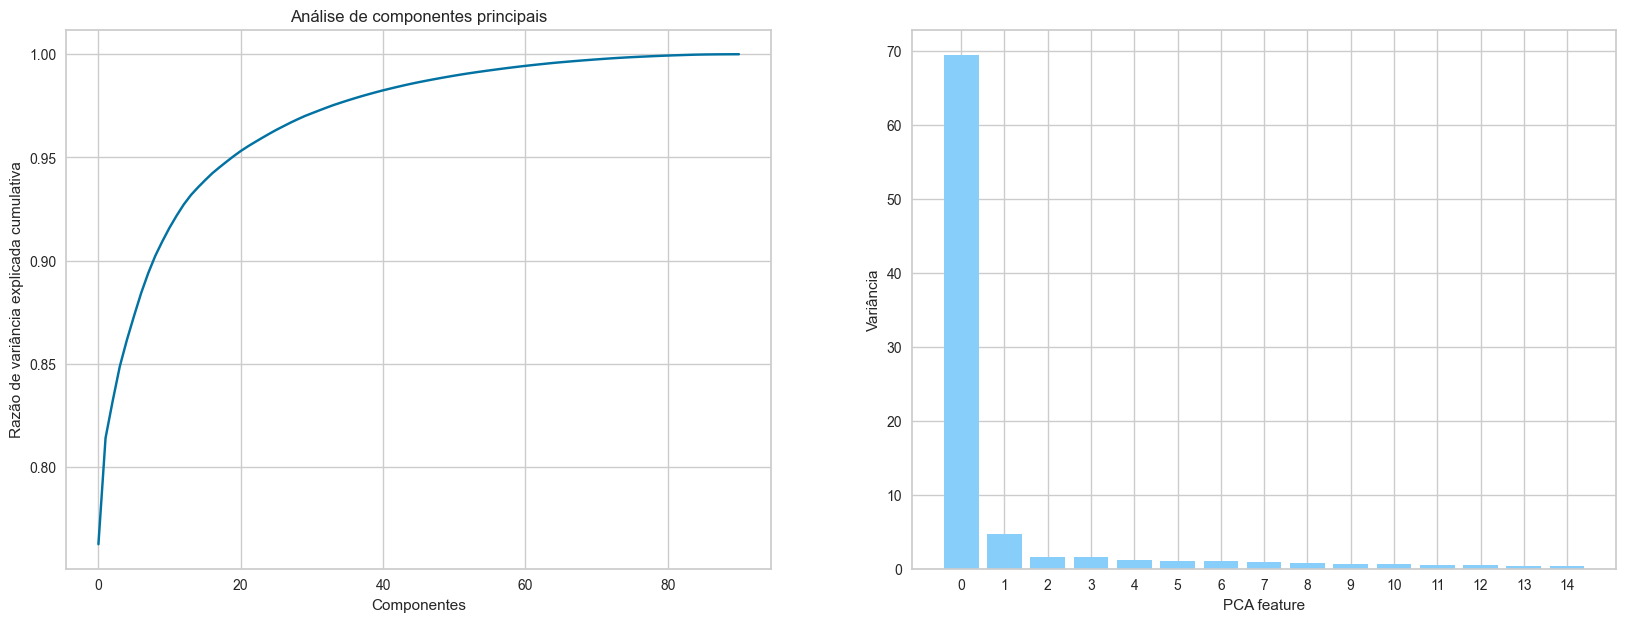

In [33]:
plt.figure(figsize=(20,7))

features = range(pipeline_pca['pca'].n_components_)
print(':', pipeline_pca['pca'].explained_variance_ratio_.cumsum()[:5].round(2))

plt.subplot(1,2,1)
plt.plot(pipeline_pca['pca'].explained_variance_ratio_.cumsum())
plt.title('Análise de componentes principais')
plt.xlabel('Componentes')
plt.ylabel('Razão de variância explicada cumulativa')

plt.subplot(1,2,2)
plt.bar(features[:15], pipeline_pca['pca'].explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variância')
plt.xticks(features[:15]);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que as duas primeiras componentes explicam 83% da variância total dos dados, vamos dar uma olhada na distribuição dos dados:
    
</div>

In [34]:
%%time 

n_components  = 2
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]
pca           = ('pca', PCA(n_components=n_components, random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])

pipeline_pca.fit(X_21)

X_21[pca_feats]      = pipeline_pca.fit_transform(X_21)
X_test_21[pca_feats] = pipeline_pca.fit_transform(X_test_21)

CPU times: total: 4 s
Wall time: 11.3 s


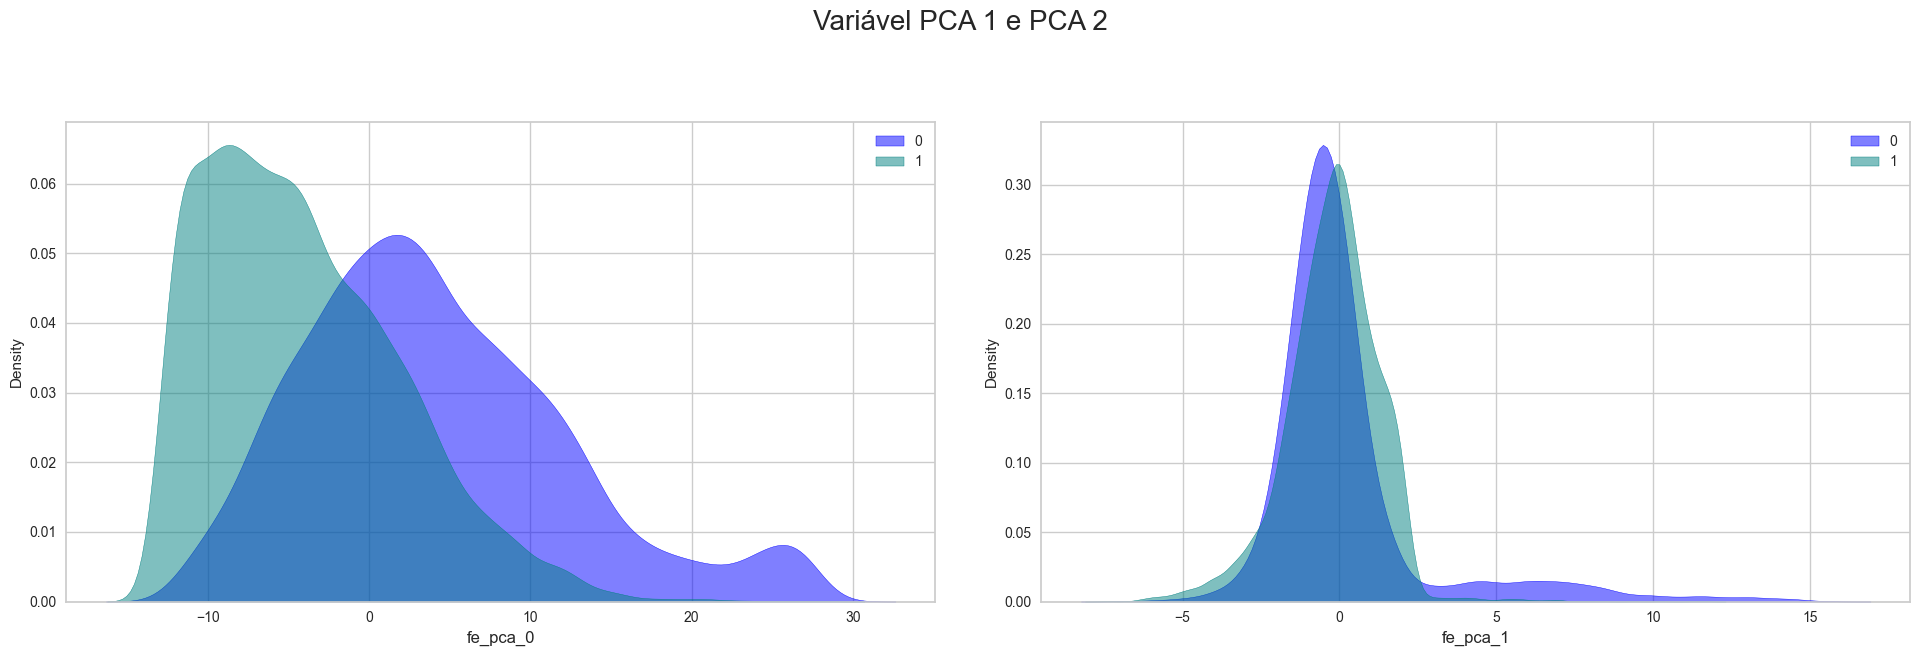

In [35]:
plt.figure(figsize=(20,7))

_ = X_21.copy() 
_[target] = y 

for i,feature in enumerate(pca_feats):
    plt.subplot(1,2,i+1)
    sns.kdeplot(_[_[target]==0][feature],color='blue', alpha=0.5, label='0', shade=True)
    sns.kdeplot(_[_[target]==1][feature],color='teal', alpha=0.5, label='1', shade=True)  
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('Variável PCA 1 e PCA 2', fontsize=20)
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar no primeiro gráfico, áreas que não se sobrepÕe em relação as classes de classificações, quando olhamos para o segundo gráfico tem uma sobreposição das áreas das classes, isso torna a classificação dos modelos difícil, vamos dar uma olha na correlação dessas variáveis. 
    
</div>

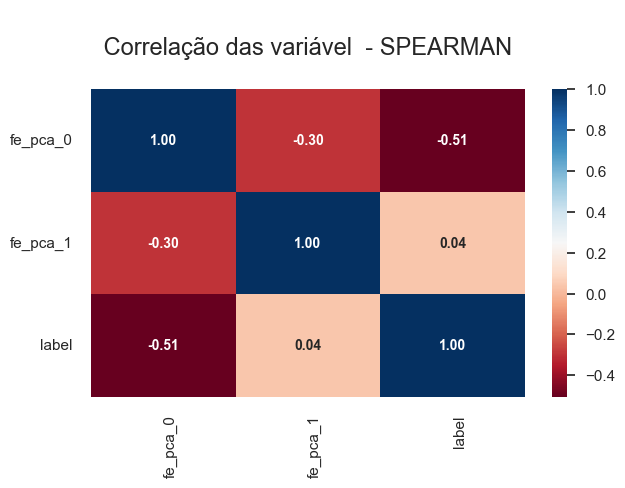

In [37]:
plt.figure(figsize=(7,4))
feature_corr = \
    utility.graf_feature_corr(df_         = _[pca_feats+[target]],                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = False, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
No gráfico de correlação fica claro que a primeira PCA tem o maior porder preditivo <b>negativo</b>, isso pode ser um problema, pois a correlação negativo pode elevar o erro de predição,  em relação a segunda PCA tem um valor muito baixo.  
    
</div>

In [38]:
X_21[pca_feats].describe()

fe_pca_0      fe_pca_1
count  2.000000e+04  2.000000e+04
mean   1.270095e-17  1.493250e-17
std    8.331198e+00  2.163806e+00
min   -1.334814e+01 -7.401571e+00
25%   -6.364707e+00 -1.082924e+00
50%   -1.011184e+00 -2.650650e-01
75%    4.766445e+00  5.984881e-01
max    2.870829e+01  1.567083e+01

In [39]:
feature_drop = ['fe_pca_1']
X_21.drop(feature_drop, axis=1, inplace=True)
X_test_21.drop(feature_drop, axis=1, inplace=True)

In [40]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_02_lgbm_nb_pca')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_21,
                 y_               = y, 
                 X_test_          = X_test_21,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 /  L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 


=> LGBM - 12359
Fold 1 => L.Loss: 0.51555 - F1-score: 0.72199 - AUC:0.73200 - 0h 0m 1s
Fold 2 => L.Loss: 0.49912 - F1-score: 0.73915 - AUC:0.74450 - 0h 0m 0s
Fold 3 => L.Loss: 0.52420 - F1-score: 0.71488 - AUC:0.72400 - 0h 0m 0s
Fold 4 => L.Loss: 0.51157 - F1-score: 0.72737 - AUC:0.74100 - 0h 0m 0s
Fold 5 => L.Loss: 0.52357 - F1-score: 0.70904 - AUC:0.71850 - 0h 0m 1s
Fold 6 => L.Loss: 0.51803 - F1-score: 0.69937 - AUC:0.71500 - 0h 0m 0s
Fold 7 => L.Loss: 0.50362 - F1-score: 0.72488 - AUC:0.73850 - 0h 0m 0s
Fold 8 => L.Loss: 0.51801 - F1-score: 0.71916 - AUC:0.73250 - 0h 0m 1s
Fold 9 => L.Loss: 0.53682 - F1-score: 0.69081 - AUC:0.70550 - 0h 0m 1s
Fold 10 => L.Loss: 0.53982 - F1-score: 0.69479 - AUC:0.70700 - 0h 0m 1s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.51903 - 0h 0m 10s

CPU times: total: 1min 9s
Wall time: 10.7 s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Não teve melhoria na submissão, mas vou permanecer com a variável.
    
</div>

## 2.2. Clustering

In [41]:
X_22      = X_21.copy()
X_test_22 = X_test_21.copy()

### 2.2.1. Todas as variáveis

In [42]:
feture_pca = X_22.columns.to_list()
feture_pca.remove('fe_pca_0')

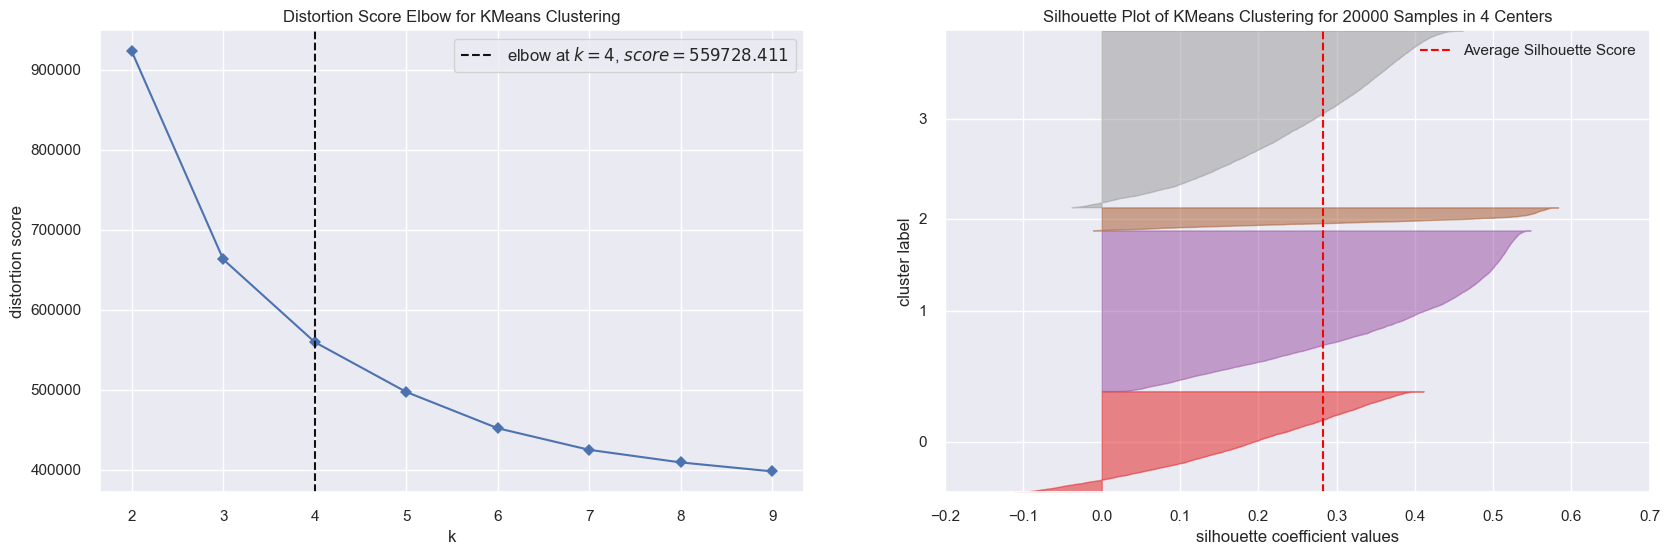

CPU times: total: 1min 26s
Wall time: 39.3 s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 20000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
%%time 
sc1 = StandardScaler().fit(X_22[feture_pca])

_ = pd.DataFrame(sc1.fit_transform(X_22[feture_pca].copy()), columns=feture_pca)

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_1 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_1, ax=axs1[1])

sv.fit(_)
sv.show();

### 2.2.2. Utilizando PCA

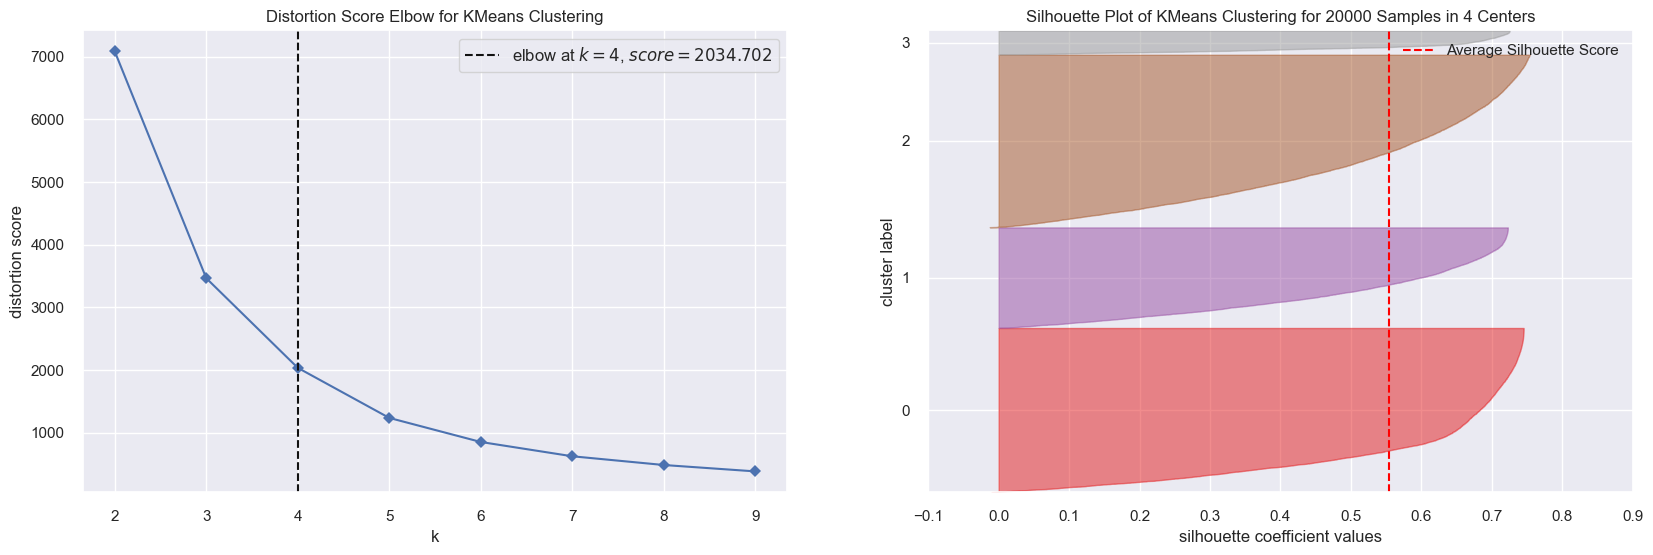

CPU times: total: 17.1 s
Wall time: 11.8 s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 20000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:
%%time 

sc2 = StandardScaler() 
_   = pd.DataFrame(sc2.fit_transform(pd.DataFrame(X_21.copy()['fe_pca_0'])), columns=['fe_pca_0'])

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_2 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_2, ax=axs1[1])

sv.fit(_)
sv.show();

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Utilizando PCA temos os clusters com melhor silhjouette e melhor distribuições em relação ao utilizar todas as variáveis para gera os clusters. 
    
Vamos gerar os clusters nos dados de treino e teste.
    
</div>

In [46]:
%%time 

X_22['fe_cluster_kmeans']      = model_2.fit_predict(sc2.fit_transform(X_22))
X_test_22['fe_cluster_kmeans'] = model_2.fit_predict(sc2.fit_transform(X_test_22))

CPU times: total: 9.45 s
Wall time: 1.86 s


In [47]:
X_22.filter(regex=r'fe').head()

fe_pca_0  fe_cluster_kmeans
0  -4.387487                  3
1   2.786561                  3
2  -4.610095                  1
3  -2.091297                  3
4 -11.117320                  1

In [48]:
%%time 
model_bgmm = BayesianGaussianMixture(n_components    = k, 
                                     covariance_type = 'full', 
                                     n_init          = 3,
                                     init_params     = "kmeans",
                                     random_state    = seed) 

X_22['fe_cluster_bgmm_pca']      = model_bgmm.fit_predict(X_22[['fe_pca_0']])
X_test_22['fe_cluster_bgmm_pca'] = model_bgmm.fit_predict(X_test_22[['fe_pca_0']])

CPU times: total: 20.6 s
Wall time: 4.78 s


### 2.2.3. Gráfico de análise

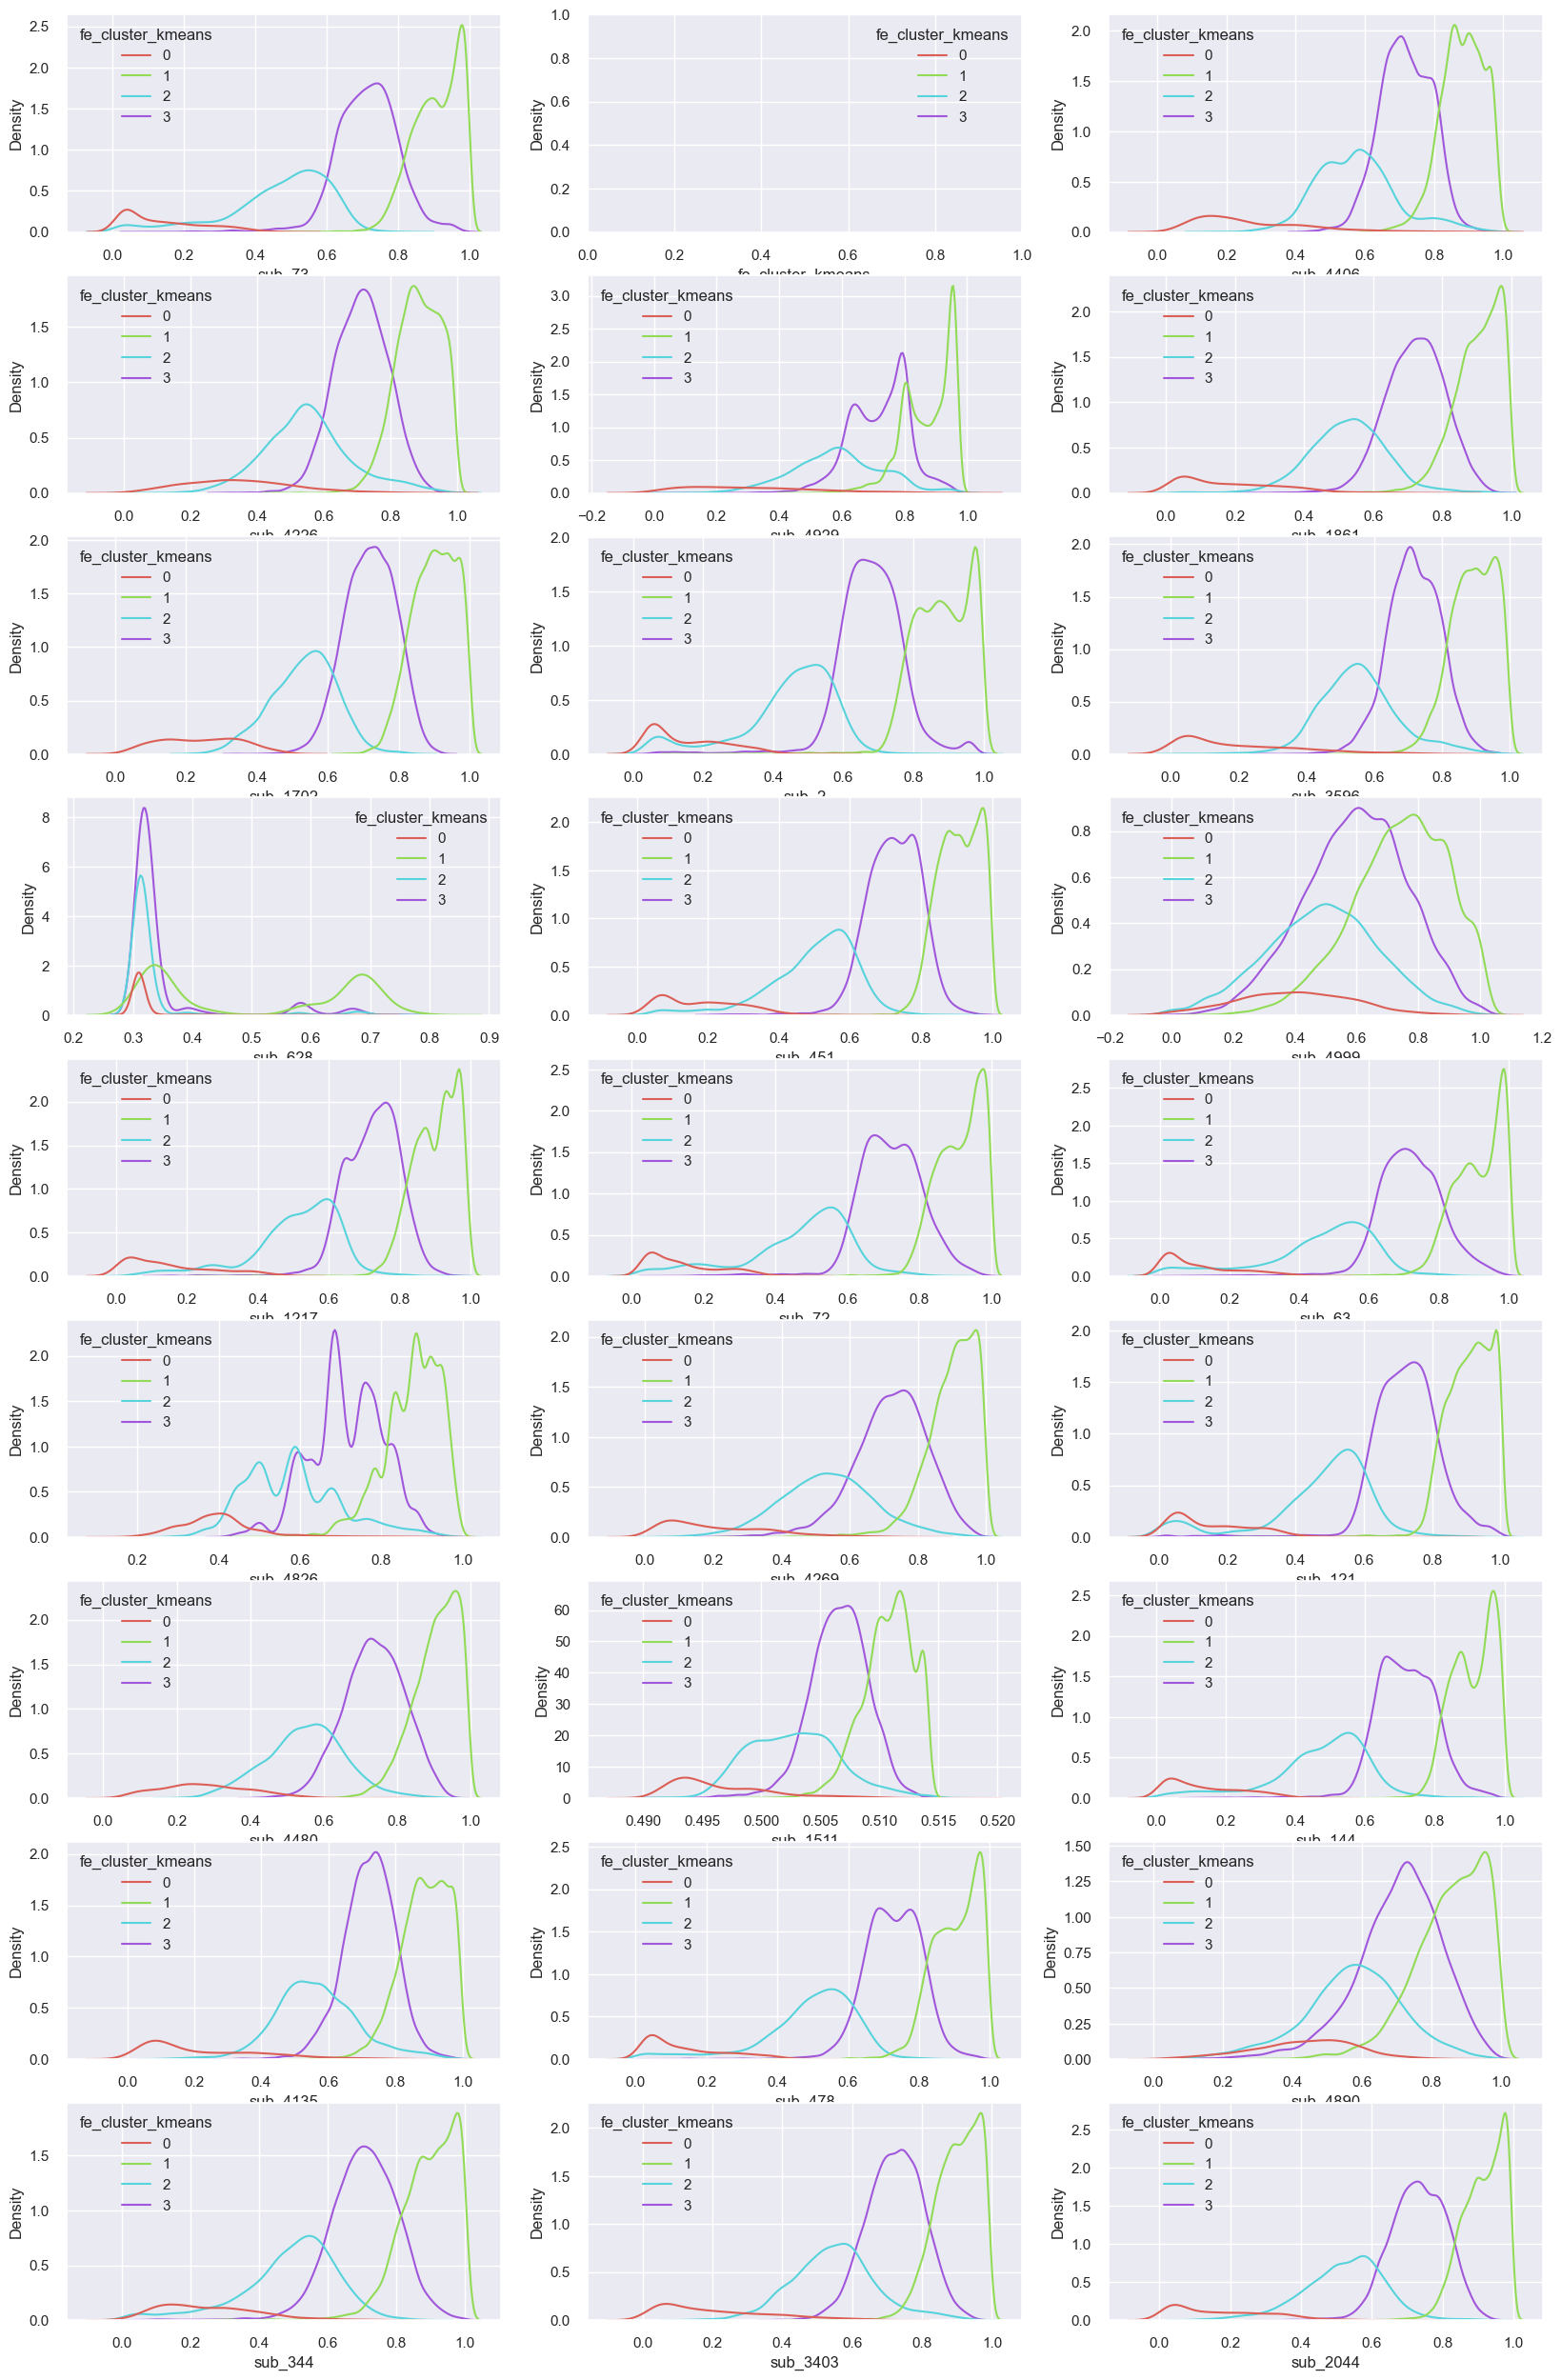

In [49]:
feature_sample = X_22.sample(27, axis='columns').columns.to_list()
row            = int(len(feature_sample)/3) + 1

f,ax = plt.subplots(figsize=(20,35))

for i, feature in enumerate(feature_sample):
    plt.subplot(row, 3 , i+1)
    sns.kdeplot(data=X_22, x=feature, hue="fe_cluster_kmeans", palette=sns.color_palette("hls", k));
    
utility.free_gpu_cache()

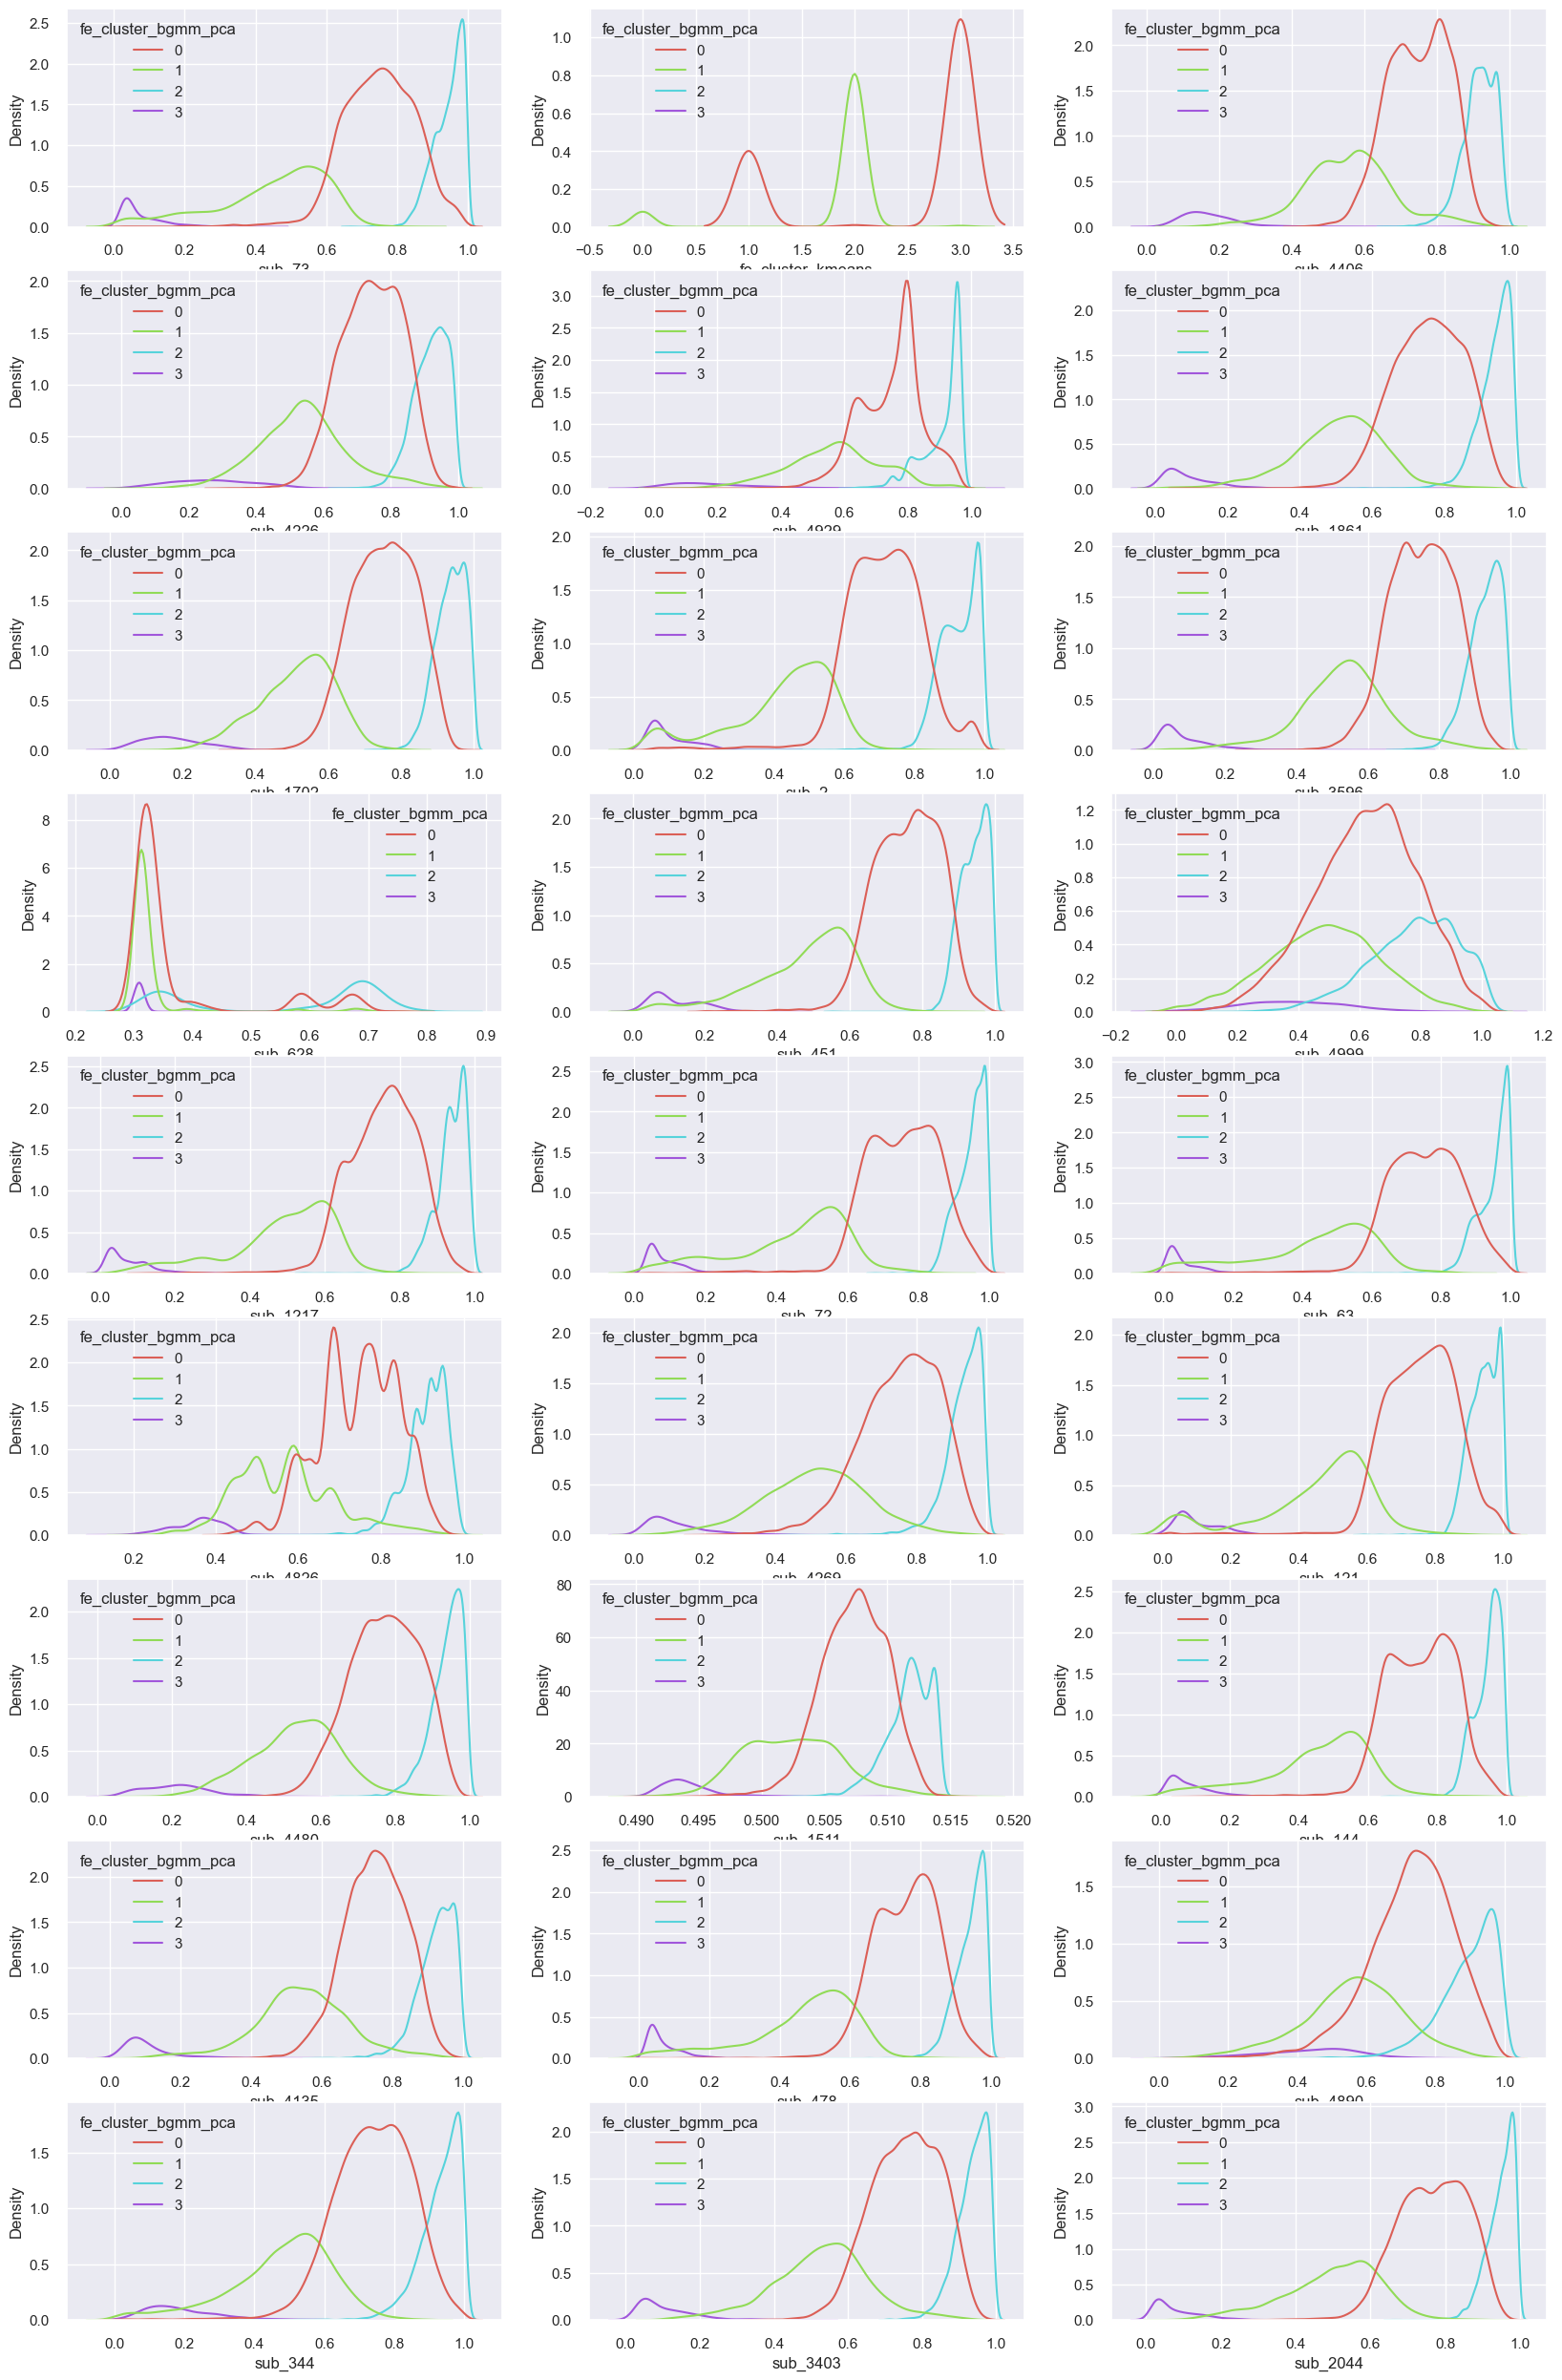

In [50]:
f,ax = plt.subplots(figsize=(20,35))

for i, feature in enumerate(feature_sample):
    plt.subplot(row, 3 , i+1)
    sns.kdeplot(data=X_22, x=feature, hue="fe_cluster_bgmm_pca", palette=sns.color_palette("hls", k));
    
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que os clusters conseguem fazer a separação dos dados, vamos dar uma olhada na correlação das variáveis criadas. 
    
</div>

In [51]:
feature_corr = ['fe_pca_0','fe_cluster_kmeans', 'fe_cluster_bgmm_pca', target]

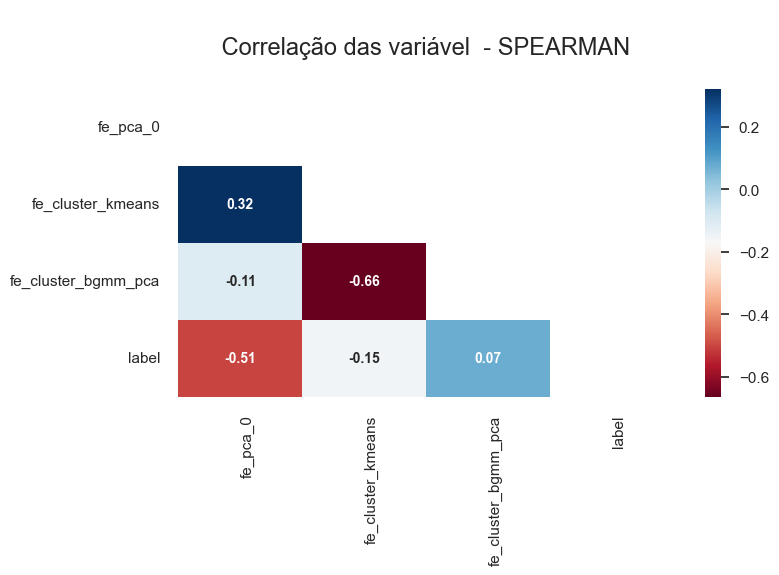

In [52]:
plt.figure(figsize=(8,4))
_ = X_22.copy() 
_[target] = y

feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temo uma alta correlação entre a PCA e o cluste gerado pelo kmeans, praticamente elas tem o mesmo pode preditivos em relação a variável alvo.

    

</div>

### 2.2.4. Criar dammy

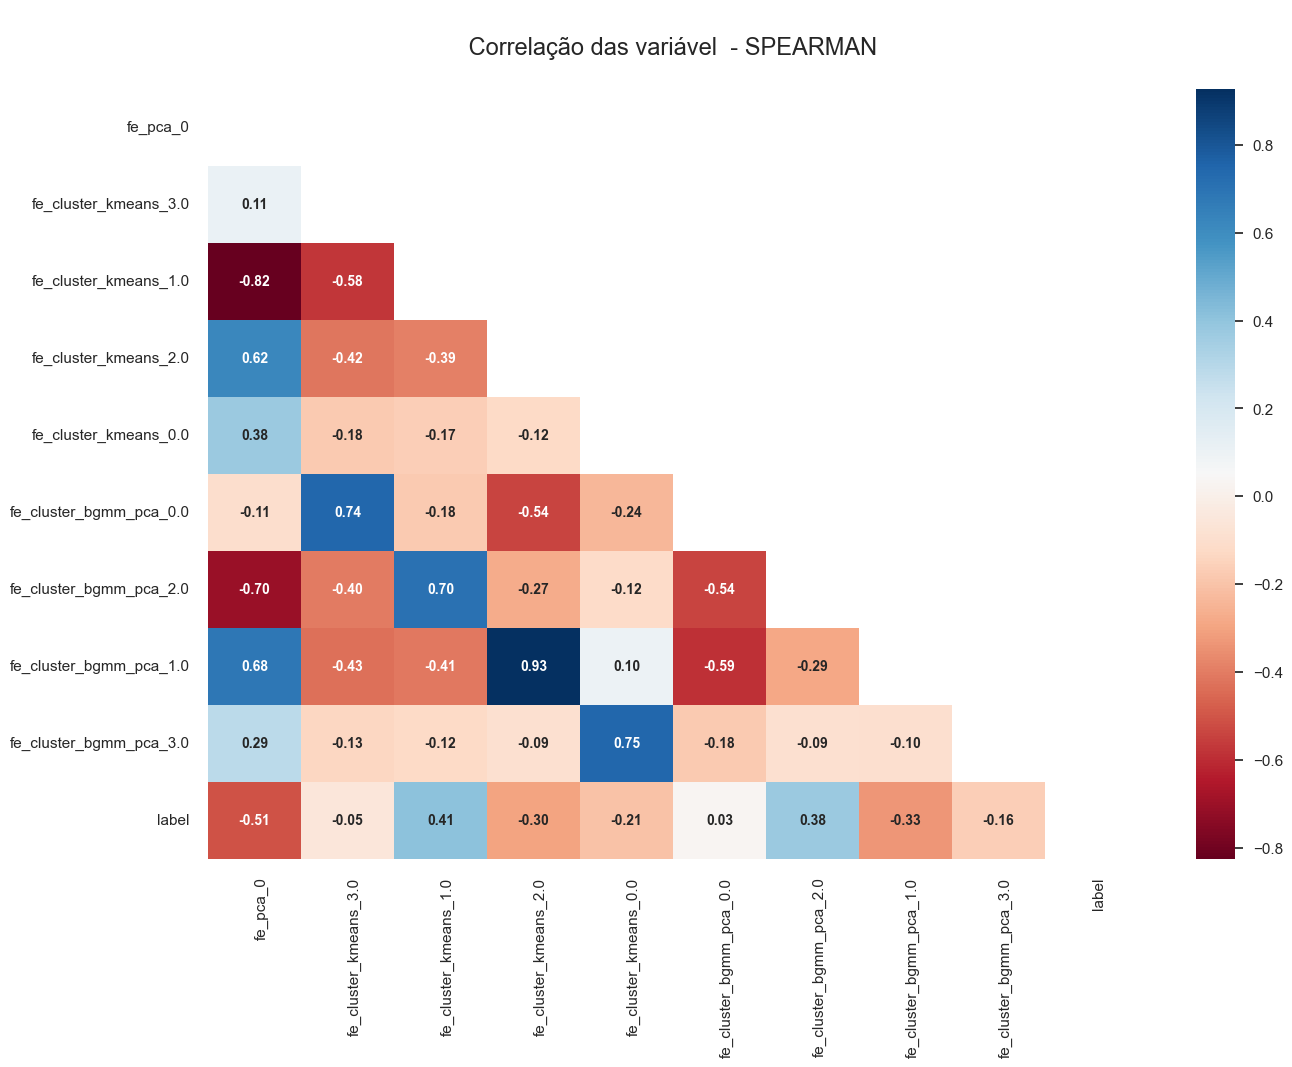

In [53]:
encoder = ce.OneHotEncoder(cols           = ['fe_cluster_bgmm_pca', 'fe_cluster_kmeans'],
                           handle_unknown = 'return_nan',
                           return_df      = True,
                           use_cat_names  = True)

encoder.fit(X_22)

_            = encoder.fit_transform(X_22)
_[target]    = y
feature_corr = _.filter(regex=r'fe_').columns.to_list()

plt.figure(figsize=(15,10))
feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr+ [target]],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Me parece que criar variáveis <b>One Hot Encoding</b> da variável cluster seja  relevante, sendo assim, vamos implentar dentro de um pipeline a criação da variáveis dammies.   
    
</div>

In [54]:
X_22.drop('fe_cluster_kmeans', axis=1, inplace=True)
X_test_22.drop('fe_cluster_kmeans', axis=1, inplace=True)

In [55]:
X_22.filter(regex=r'fe_').head()

fe_pca_0  fe_cluster_bgmm_pca
0  -4.387487                    0
1   2.786561                    0
2  -4.610095                    0
3  -2.091297                    0
4 -11.117320                    2

In [56]:
X_test_22.filter(regex=r'fe_').head()

fe_pca_0  fe_cluster_bgmm_pca
0 -5.108307                    1
1 -3.917304                    1
2  6.549943                    0
3  2.588969                    1
4  5.010249                    0

In [57]:
X_22.shape, X_test_22.shape

((20000, 93), (20000, 93))

### 2.2.5. Modelo sem dammy

In [58]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_03_lgbm_nb_02_cluster_sem_dammy')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_22,
                 y_               = y, 
                 X_test_          = X_test_22,                  
                 path_            = path, 
                 seed_           = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 / L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 
# L.Loss: 0.52109 / L.Loss: 0.52037


=> LGBM - 12359
Fold 1 => L.Loss: 0.51567 - F1-score: 0.72349 - AUC:0.73400 - 0h 0m 1s
Fold 2 => L.Loss: 0.49885 - F1-score: 0.74097 - AUC:0.74550 - 0h 0m 0s
Fold 3 => L.Loss: 0.52450 - F1-score: 0.71214 - AUC:0.72150 - 0h 0m 1s
Fold 4 => L.Loss: 0.51210 - F1-score: 0.72603 - AUC:0.73850 - 0h 0m 1s
Fold 5 => L.Loss: 0.52405 - F1-score: 0.70497 - AUC:0.71500 - 0h 0m 1s
Fold 6 => L.Loss: 0.51906 - F1-score: 0.69853 - AUC:0.71300 - 0h 0m 1s
Fold 7 => L.Loss: 0.50336 - F1-score: 0.72546 - AUC:0.73850 - 0h 0m 1s
Fold 8 => L.Loss: 0.51832 - F1-score: 0.72017 - AUC:0.73500 - 0h 0m 1s
Fold 9 => L.Loss: 0.53623 - F1-score: 0.69013 - AUC:0.70500 - 0h 0m 1s
Fold 10 => L.Loss: 0.53989 - F1-score: 0.69588 - AUC:0.70850 - 0h 0m 1s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.51920 - 0h 0m 11s

CPU times: total: 1min 12s
Wall time: 11.9 s


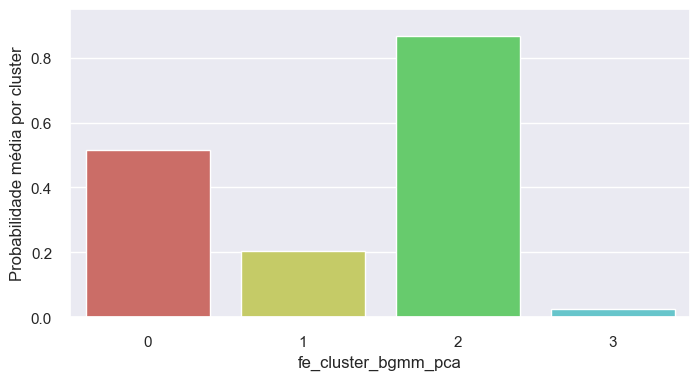

In [60]:
_ =  X_22.copy()
_['pred_proba'] =  y
_ = _.groupby('fe_cluster_bgmm_pca')['pred_proba'].mean()
f,ax = plt.subplots(figsize=(8,4))
sns.barplot(x=_.index, y=_.values, palette=sns.color_palette("hls", 6) );
ax.set_ylabel("Probabilidade média por cluster");
ax.set_ylim([0.,0.95]);

### 2.2.6. Modelo com dammy 

In [61]:
param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm = lgb.LGBMClassifier(**param_lgbm)

# Processamento
feature_encoder_bin = X_22.filter(regex='fe_c').columns.to_list()
processar           = ('preprocessor', StandardScaler())
variancethreshold   = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile    = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest         = ('SelectKBest', SelectKBest(score_func=f_classif))
encoder_bin         = ('encoder_binary', ce.BinaryEncoder(cols=feature_encoder_bin, return_df=True))
mdl_lgbm            = ('model', model_lgbm)

# Pipelne 
model_pipeline_lgbm = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, mdl_lgbm])

In [62]:

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_04_lgbm_nb_02_cluster_com_dammy')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_22,
                 y_               = y, 
                 X_test_          = X_test_22,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')


# L.Loss: 0.52108 / L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 
# L.Loss: 0.52109 / L.Loss: 0.52037


=> LGBM - 12359
Fold 1 => L.Loss: 0.51614 - F1-score: 0.72416 - AUC:0.73450 - 0h 0m 1s
Fold 2 => L.Loss: 0.49887 - F1-score: 0.73968 - AUC:0.74450 - 0h 0m 1s
Fold 3 => L.Loss: 0.52388 - F1-score: 0.71185 - AUC:0.72150 - 0h 0m 1s
Fold 4 => L.Loss: 0.51199 - F1-score: 0.72412 - AUC:0.73750 - 0h 0m 1s
Fold 5 => L.Loss: 0.52446 - F1-score: 0.70497 - AUC:0.71500 - 0h 0m 1s
Fold 6 => L.Loss: 0.51831 - F1-score: 0.69868 - AUC:0.71450 - 0h 0m 1s
Fold 7 => L.Loss: 0.50369 - F1-score: 0.72459 - AUC:0.73850 - 0h 0m 1s
Fold 8 => L.Loss: 0.51816 - F1-score: 0.72114 - AUC:0.73550 - 0h 0m 1s
Fold 9 => L.Loss: 0.53600 - F1-score: 0.68973 - AUC:0.70400 - 0h 0m 1s
Fold 10 => L.Loss: 0.53945 - F1-score: 0.69579 - AUC:0.70750 - 0h 0m 1s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.51910 - 0h 0m 12s



<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A transformação da variável cluster em dammy não melhou o desempenho do modelo.   
    
</div>

# 3. Modelagem

## 3.2. Definindo o pipeline

In [63]:
# Paremetros 

params_xgb  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'max_depth'        : 7,  
    'colsample_bytree' : 0.8, 
    'max_leaves'       : 10,    # 0.52463    
    'subsample'        : 0.95,  # 0.52460
    'seed'             : seed}

params_xgb_2  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'max_depth'        : 4,  
    'colsample_bytree' : 0.8, 
    'max_leaves'       : 10,    # 0.52463    
    #'subsample'        : 0.95,  # 0.52460              
    #'alpha'            : 0.9,   # 
    'n_jobs'           : -1,
    'seed'             : seed}

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_lgbm_2  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 12,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 500,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 100,
    'max_depth'         : 7,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

param_rf_2    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 500,
    'max_depth'         : 15,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

param_ext   = {
    'n_estimators'     : 500,
    'max_depth'        : 7, 
    'min_samples_leaf' : 12,         
    'n_jobs'           : -1,
    'random_state'     : seed}

param_ext_2   = {
    'n_estimators'     : 1000,
    'max_depth'        : 12, 
    'min_samples_leaf' : 12,         
    'n_jobs'           : -1,
    'random_state'     : seed}


param_lr    = {
    'max_iter'      : 1000, 
    'C'             : 0.0001, 
    'penalty'       : 'l2', 
    'fit_intercept' : True,
    'solver'        : 'newton-cg'}

param_mlp   = {
    'learning_rate' : 'adaptive',
    'alpha'         : 0.5,
    'random_state'  : seed}

param_mlp_2 = {
    'learning_rate' : 'adaptive',
    'activation'    : 'relu',
    'max_iter'      : 100, 
    'alpha'         : 0.5,
    'batch_size'    : 256*2*2*2, 
    'random_state'  : seed}

param_hbc   = {
    'max_iter'            : 100,
    'validation_fraction' : 0.1,
    'random_state'        : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_lr      = LogisticRegression(**param_lr)
model_knn     = KNeighborsClassifier(n_neighbors=225) 
model_knn_100 = KNeighborsClassifier(n_neighbors=100)
model_knn_50  = KNeighborsClassifier(n_neighbors=50)
model_mlp     = MLPClassifier(**param_mlp) 
model_mlp_2   = MLPClassifier(**param_mlp_2) 
model_xgb     = xgb.XGBClassifier(**params_xgb) 
model_xgb_2   = xgb.XGBClassifier(**params_xgb_2) 
model_ext     = ExtraTreesClassifier(**param_ext)
model_ext_2   = ExtraTreesClassifier(**param_ext_2)
model_lgbm    = lgb.LGBMClassifier(**param_lgbm)
model_lgbm_2  = lgb.LGBMClassifier(**param_lgbm_2)
model_rf      = RandomForestClassifier(**param_rf)
model_rf_2    = RandomForestClassifier(**param_rf_2)
model_hbc     = HistGradientBoostingClassifier(**param_hbc)

pca    = ('pca', PCA(n_components=80, random_state=seed))
scaler = StandardScaler() 

# Processamento
encoder_bin       = ('encoder_binary', ce.BinaryEncoder(cols=feature_encoder_bin, return_df=True))
processar         = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Preciso normalizar as duas últimas colunas 
_ = X_22.columns.to_list()
_.remove('fe_pca_0')
_.remove('fe_cluster_bgmm_pca')

pipeline_SimpleImputer  = Pipeline([('imputer', SimpleImputer(strategy="median"))])
pipeline_StandardScaler = Pipeline([('standard', scaler)])
pipeline_MaxAbsScaler   = Pipeline([('cluster', MaxAbsScaler() )])

# Compondo os pré-processadores
pipiline_ColumnTransformer = ColumnTransformer(transformers=[    
    ('SimpleImputer', pipeline_SimpleImputer, _),
    ('StandardScaler', pipeline_StandardScaler, ['fe_pca_0']),
    ('MaxAbsScaler', pipeline_MaxAbsScaler, ['fe_cluster_bgmm_pca'])
])

process_tensorflow = Pipeline(steps=[processar, variancethreshold, selectpercentile])
columntransf       = ('ColumnTransformer', pipiline_ColumnTransformer)

# Pipelne 
pipeline_lr       = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lr)])
pipeline_knn      = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn)])  
pipeline_mlp      = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_mlp)])
pipeline_xgb      = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_xgb)])
pipeline_ext      = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_ext)])
pipeline_lgbm     = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm)])
pipeline_rf       = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf)])
pipeline_hbc      = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_hbc)])

pipeline_knn_100  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn_100)])
pipeline_knn_50   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn_50)])
pipeline_mlp_2    = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_mlp_2)])

pipeline_xgb_2    = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_xgb_2)])
pipeline_lgbm_2   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm_2)])
pipeline_rf_2     = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf_2)])
pipeline_ext_2    = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_ext_2)])

model_tensorflow, early_stopping, plateau = create_model(input_shape_= X_test[feature_selec_fsm].shape[1])

## 3.3. Funções da modelagem

## 3.4. Treino

In [64]:
X_22.shape, X_test_22.shape

((20000, 93), (20000, 93))

In [65]:
%%time

models = [ 
    ('LR', pipeline_lr, 1, 'nb_02_n2_05_lr'), 
    ('KNN', pipeline_knn, 1, 'nb_02_n2_06_knn'),     
    ('MLP', pipeline_mlp, 1, 'nb_02_n2_07_mlp' ),
    ('XGB', pipeline_xgb, 1, 'nb_02_n2_08_xgb'),    
    ('ExTrees', pipeline_ext, 1, 'nb_02_n2_09_extrees'),    
    ('LGBM', pipeline_lgbm, 1, 'nb_02_n2_10_lgbm'), 
    ('RForest', pipeline_rf, 1, 'nb_02_n2_11_rforest'),
    ('HBoosting', pipeline_hbc, 1,'nb_02_n2_12_hboosting'),
    ('KNN_100', pipeline_knn_100, 1,'nb_02_n2_13_knn_100'),
    ('KNN_50', pipeline_knn_50, 1,'nb_02_n2_14_knn_50'),
    ('MLP_2', pipeline_mlp_2, 1, 'nb_02_n2_15_mlp_2' ), 
    ('XGB_2', pipeline_xgb_2, 1, 'nb_02_n2_16_xgb_2'),
    ('LGBM_2', pipeline_lgbm_2, 1, 'nb_02_n2_17_lgbm_2'), 
    ('RForest_2', pipeline_rf_2, 1, 'nb_02_n2_18_rforest_2'),
    ('ExTrees_2', pipeline_ext_2, 1, 'nb_02_n2_19_extrees_2'), 
    ('Tensorflow', model_tensorflow, 3, 'nb_02_n2_20_tensorflow', early_stopping, plateau, process_tensorflow)
    ]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_       = models, 
                 X_            = X_22.copy(),
                 y_            = y, 
                 X_test_       = X_test_22.copy(),                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True, 
                 save_ensamble_= True,
                 level_        = '2')


=> LR - 12359
Fold 1 => L.Loss: 0.52724 - F1-score: 0.71858 - AUC:0.72350 - 0h 0m 1s
Fold 2 => L.Loss: 0.51013 - F1-score: 0.73547 - AUC:0.73600 - 0h 0m 0s
Fold 3 => L.Loss: 0.53269 - F1-score: 0.71149 - AUC:0.71250 - 0h 0m 0s
Fold 4 => L.Loss: 0.52264 - F1-score: 0.72940 - AUC:0.73400 - 0h 0m 0s
Fold 5 => L.Loss: 0.53146 - F1-score: 0.71197 - AUC:0.71600 - 0h 0m 0s
Fold 6 => L.Loss: 0.52738 - F1-score: 0.70456 - AUC:0.71150 - 0h 0m 0s
Fold 7 => L.Loss: 0.51625 - F1-score: 0.72074 - AUC:0.72800 - 0h 0m 0s
Fold 8 => L.Loss: 0.52511 - F1-score: 0.72596 - AUC:0.73350 - 0h 0m 0s
Fold 9 => L.Loss: 0.54008 - F1-score: 0.70732 - AUC:0.71200 - 0h 0m 0s
Fold 10 => L.Loss: 0.54780 - F1-score: 0.70535 - AUC:0.70800 - 0h 0m 0s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52808 - 0h 0m 6s

              precision    recall  f1-score   support

           0       0.71      0.74      0.73     10000
           1       0.73      0.71      0.72     100

Fold 1 => L.Loss: 0.51883 - F1-score: 0.72046 - AUC:0.73150 - 0h 0m 7s
Fold 2 => L.Loss: 0.50242 - F1-score: 0.73690 - AUC:0.74150 - 0h 0m 7s
Fold 3 => L.Loss: 0.52640 - F1-score: 0.70814 - AUC:0.71850 - 0h 0m 8s
Fold 4 => L.Loss: 0.51459 - F1-score: 0.72114 - AUC:0.73550 - 0h 0m 7s
Fold 5 => L.Loss: 0.52701 - F1-score: 0.70376 - AUC:0.71250 - 0h 0m 7s
Fold 6 => L.Loss: 0.52304 - F1-score: 0.70133 - AUC:0.71850 - 0h 0m 7s
Fold 7 => L.Loss: 0.50956 - F1-score: 0.72327 - AUC:0.73600 - 0h 0m 7s
Fold 8 => L.Loss: 0.51871 - F1-score: 0.72017 - AUC:0.73500 - 0h 0m 7s
Fold 9 => L.Loss: 0.53696 - F1-score: 0.69118 - AUC:0.70600 - 0h 0m 7s
Fold 10 => L.Loss: 0.54070 - F1-score: 0.69651 - AUC:0.70850 - 0h 0m 7s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52182 - 0h 1m 19s

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     10000
           1       0.74      0.68      0.71     10000

    accura

Fold 2 => L.Loss: 0.49898 - F1-score: 0.74074 - AUC:0.74450 - 0h 0m 2s
Fold 3 => L.Loss: 0.52544 - F1-score: 0.72191 - AUC:0.72650 - 0h 0m 2s
Fold 4 => L.Loss: 0.51347 - F1-score: 0.71792 - AUC:0.72850 - 0h 0m 2s
Fold 5 => L.Loss: 0.52837 - F1-score: 0.70752 - AUC:0.71600 - 0h 0m 2s
Fold 6 => L.Loss: 0.51875 - F1-score: 0.70864 - AUC:0.72000 - 0h 0m 2s
Fold 7 => L.Loss: 0.50287 - F1-score: 0.73120 - AUC:0.73900 - 0h 0m 2s
Fold 8 => L.Loss: 0.52144 - F1-score: 0.71712 - AUC:0.72900 - 0h 0m 2s
Fold 9 => L.Loss: 0.53542 - F1-score: 0.70588 - AUC:0.71500 - 0h 0m 2s
Fold 10 => L.Loss: 0.53722 - F1-score: 0.70231 - AUC:0.71050 - 0h 0m 2s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.51970 - 0h 0m 22s

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     10000
           1       0.74      0.70      0.72     10000

    accuracy                           0.73     20000
   macro avg       0.73    

INFO:tensorflow:Assets written to: model/mdl/nb_02_n2_20_tensorflow_0.52385_folds_10_seed_12359.csv.pkl.z\assets


INFO:tensorflow:Assets written to: model/mdl/nb_02_n2_20_tensorflow_0.52385_folds_10_seed_12359.csv.pkl.z\assets


-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52385 - 0h 8m 13s

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10000
           1       0.74      0.69      0.72     10000

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000

[[7528 2472]
 [3053 6947]]


score
LR          0.51935
KNN         0.51970
MLP         0.52017
XGB         0.52182
ExTrees     0.52263
LGBM        0.52281
RForest     0.52385
HBoosting   0.52473
KNN_100     0.52589
KNN_50      0.52699
MLP_2       0.52808
XGB_2       0.53324
LGBM_2      0.53461
RForest_2   0.53762
ExTrees_2   0.54452
Tensorflow  0.58318


CPU times: total: 1h 28min 4s
Wall time: 26min 18s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões todos os modelos tiveram score melhor que no treinamento na LB pública, o melhor modelo foi <b>LGBM</b>, abaixo as submissÕes:


</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. ANÁLISE DAS PREVISÕES </h1>    
</div>

## 4.1. Distribuição e calibração

In [66]:
#df_pred_tr = jb.load(path+path_data +'pkl/df_pred_tr_n2.pkl.z' )
#df_pred_ts = jb.load(path+path_data +'pkl/df_pred_ts_n2.pkl.z' )

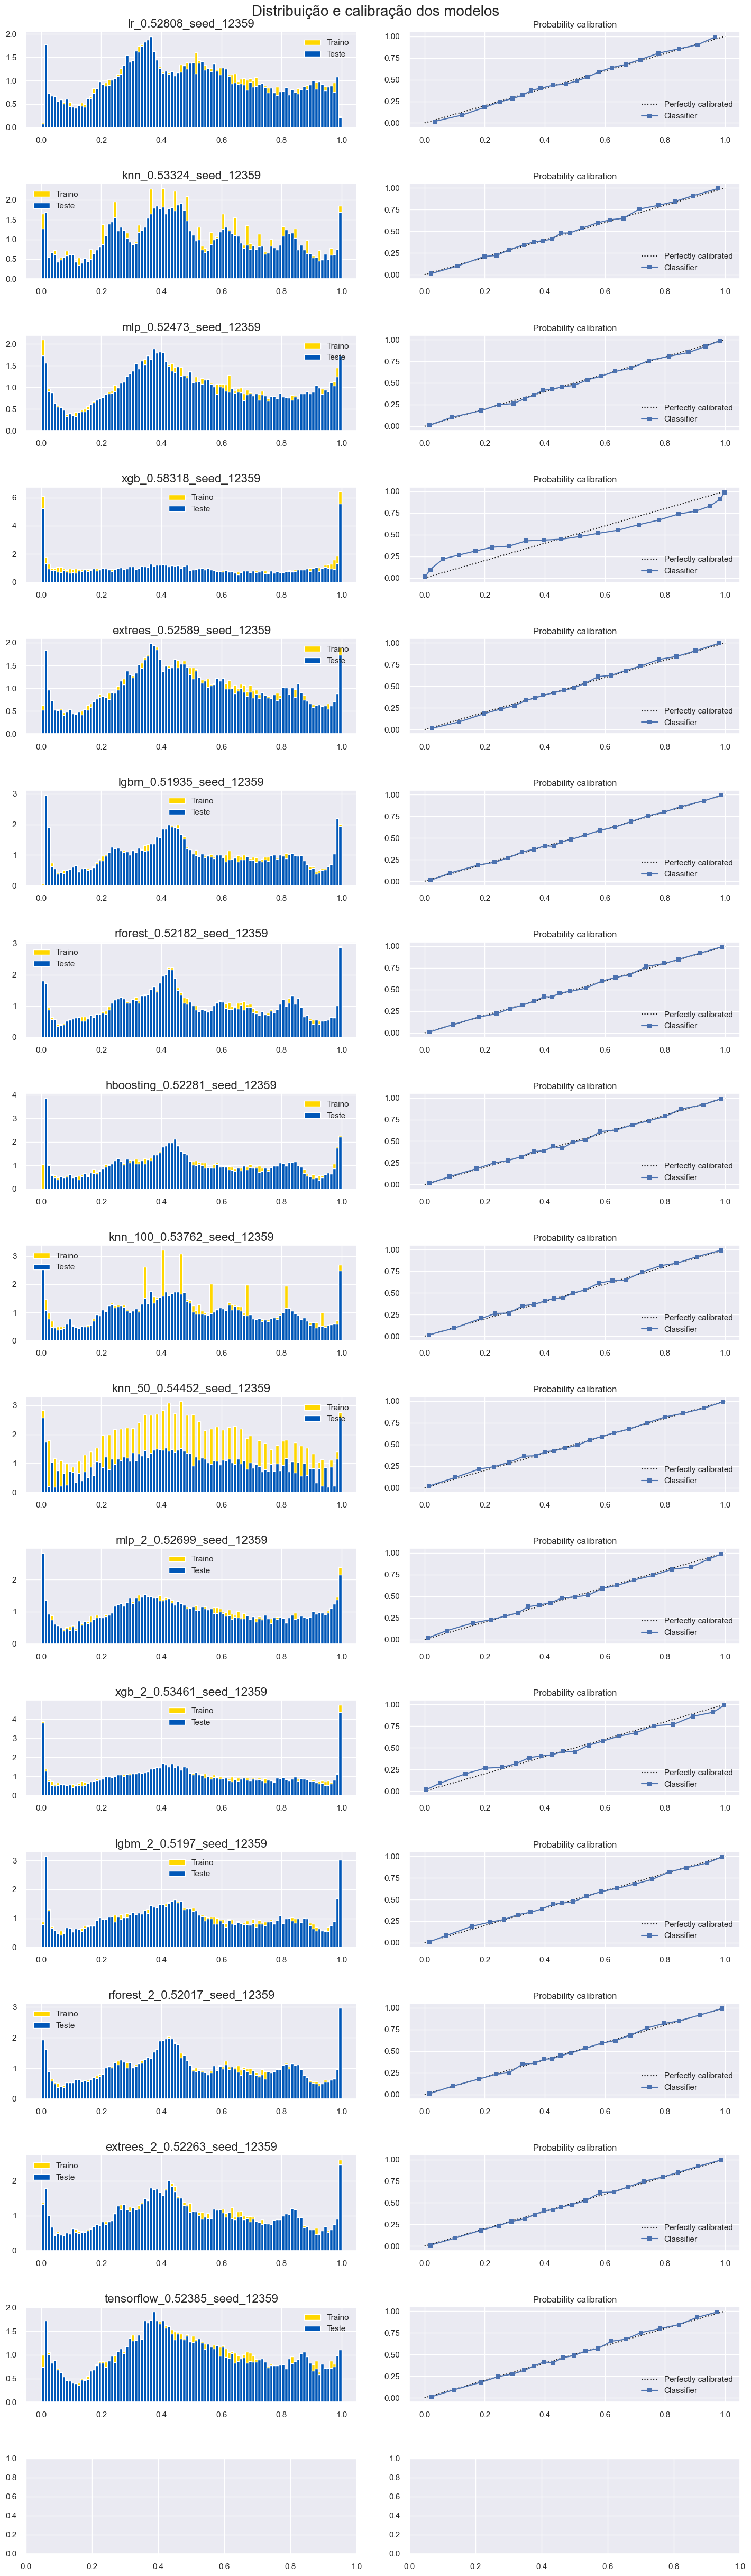

In [67]:
cols = df_pred_tr.columns.to_list()
row  = int(len(cols))
cols.remove('fold')

fig, axs = plt.subplots(row, 2, figsize=(15, 50)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A maioria dos modelos tem um boa calibração, exceto a MLP, em relação a distribuição das previsões em ambos os datasets apresentam a mesma distribuição. Alguns modelo pondem ser melhorados com ajuste de parametros. 
    
    
</didv>

## 4.2. Correlação

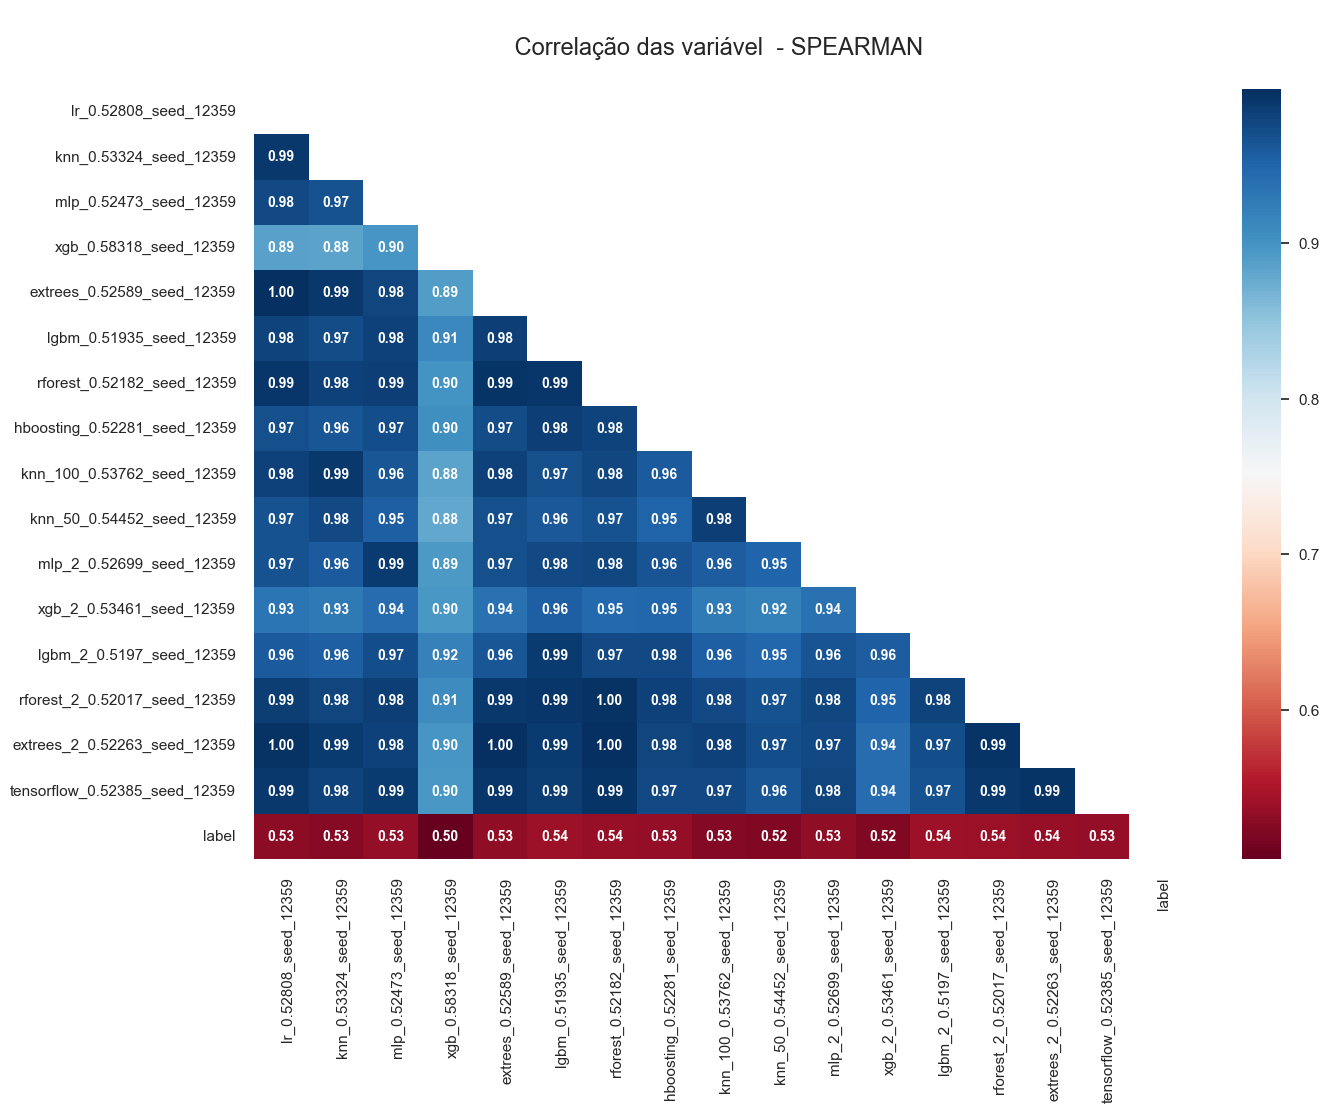

In [68]:
plt.figure(figsize=(15,10))
_ = df_pred_tr.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _.drop(['fold'], axis=1),                             
                              annot_      = True, 
                              threshold_  = .99, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Todos os modelos tem uma baixa correlação com a variável alvo, porem entre as previsões temos uma autocorreção, não vou me preocupar neste momento com essa auto correlação, pois mais tarde vamos fazer uma seleção da melhores variáveis para o próximo nível.     
    
</div>

## 4.3. Média ponderada

Vamos fazer dos modelos. 

In [69]:
def get_oof_roc_score(df_, y_, weight_, pred_model1_, pred_model2_):
    blend_pred = (df_[pred_model1_]*weight_)+(df_[pred_model2_]*(1 - weight_))
    score      = log_loss(y_, blend_pred)
    return score

In [70]:
%%time 

feature_mdl      = df_pred_tr.columns.to_list()
myscores_mdl     = []
best_mdl_score_1 = []

feature_mdl.remove('fold')

for mdl_1 in feature_mdl:     
    f = feature_mdl.copy() 
    f.remove(mdl_1)   
    for mdl_2 in f: 
        myscores    = {}
        best        = 1.
        best_weight = 0.

        for weight in range(100):            
            weight /= 100.
            score = get_oof_roc_score(df_          = df_pred_tr, 
                                      y_           = y,
                                      weight_      = weight, 
                                      pred_model1_ = mdl_1,  
                                      pred_model2_ = mdl_2)

            if score < best:
                best        = score
                best_weight = weight                

            myscores[weight] = score

    best_mdl_score_1.append({'model_1' : mdl_1, 
                             'model_2' : mdl_2, 
                             'score'   : round(best, 5), 
                             'weight'  : best_weight})

    msg = 'Best Weight: {:2.5f} - Score: {:2.5f} => {} - {}'
    print(msg.format(best_weight, best, mdl_1, mdl_2))  
    
_ = pd.DataFrame(best_mdl_score_1).sort_values('score')

print()
display(_)

print()

Best Weight: 0.00000 - Score: 0.52385 => lr_0.52808_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.05000 - Score: 0.52384 => knn_0.53324_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.43000 - Score: 0.52299 => mlp_0.52473_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.17000 - Score: 0.52209 => xgb_0.58318_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.12000 - Score: 0.52381 => extrees_0.52589_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.92000 - Score: 0.51931 => lgbm_0.51935_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.85000 - Score: 0.52172 => rforest_0.52182_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.57000 - Score: 0.52108 => hboosting_0.52281_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.15000 - Score: 0.52369 => knn_100_0.53762_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.17000 - Score: 0.52353 => knn_50_0.54452_seed_12359 - tensorflow_0.52385_seed_12359
Best Weight: 0.3600

model_1                        model_2    score  \
12       lgbm_2_0.5197_seed_12359  tensorflow_0.52385_seed_12359  0.51833   
5         lgbm_0.51935_seed_12359  tensorflow_0.52385_seed_12359  0.51931   
13   rforest_2_0.52017_seed_12359  tensorflow_0.52385_seed_12359  0.52013   
7    hboosting_0.52281_seed_12359  tensorflow_0.52385_seed_12359  0.52108   
11       xgb_2_0.53461_seed_12359  tensorflow_0.52385_seed_12359  0.52144   
6      rforest_0.52182_seed_12359  tensorflow_0.52385_seed_12359  0.52172   
3          xgb_0.58318_seed_12359  tensorflow_0.52385_seed_12359  0.52209   
14   extrees_2_0.52263_seed_12359  tensorflow_0.52385_seed_12359  0.52255   
15  tensorflow_0.52385_seed_12359   extrees_2_0.52263_seed_12359  0.52255   
10       mlp_2_0.52699_seed_12359  tensorflow_0.52385_seed_12359  0.52267   
2          mlp_0.52473_seed_12359  tensorflow_0.52385_seed_12359  0.52299   
9       knn_50_0.54452_seed_12359  tensorflow_0.52385_seed_12359  0.52353   
8      knn_100_0.53762_seed_12359  tensorflow_0.52385_seed_12359  0.52369   
4      extrees_0.52589_seed_12359  tensorflow_0.52385_seed_12359  0.52381   
1          knn_0.53324_seed_12359  tensorflow_0.52385_seed_12359  0.52384   
0           lr_0.52808_seed_12359  tensorflow_0.52385_seed_12359  0.52385   

    weight  
12    0.69  
5     0.92  
13    0.93  
7     0.57  
11    0.33  
6     0.85  
3     0.17  
14    0.81  
15    0.19  
10    0.36  
2     0.43  
9     0.17  
8     0.15  
4     0.12  
1     0.05  
0     0.00


CPU times: total: 2min 1s
Wall time: 2min 1s


In [71]:
mdl_1 = str(_[:1].values[:,:1]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
mdl_2 = str(_[:1].values[:,1:2]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
weight = np.float64(str(_[:1].values[:,3:4]).replace("[", '').replace("'",'').replace("]", '').replace("'",''))

name = 'nb_02_n2_21_emsable_average_{}_w1_{}_{}.csv'.format(mdl_1, weight, mdl_2)
df_submission['pred'] = df_pred_ts[mdl_1]*weight + df_pred_ts[mdl_2]*(1-weight)
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51598 - n2_01_emsable_average_LGBM_0.52022_HBoosting_0.52385.csv

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Na submissão da media ponderada do HBoosting e RForest se mostrou promissor com score de 0.51669, passando a ser melhor que a maior dos modelos. 
 
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

# 5. Terceiro Nível
Nesta parte do processo vamos pegar as previsões que foram geradas no segundo nível e fazer novas previsões com os modelos que foram utilizados, ao fazer as previsões vamos remover o modelo que faz a previsão do dataset.  

In [72]:
df_pred_tr.columns

Index(['lr_0.52808_seed_12359', 'knn_0.53324_seed_12359',
       'mlp_0.52473_seed_12359', 'xgb_0.58318_seed_12359',
       'extrees_0.52589_seed_12359', 'lgbm_0.51935_seed_12359',
       'rforest_0.52182_seed_12359', 'hboosting_0.52281_seed_12359',
       'knn_100_0.53762_seed_12359', 'knn_50_0.54452_seed_12359',
       'mlp_2_0.52699_seed_12359', 'xgb_2_0.53461_seed_12359',
       'lgbm_2_0.5197_seed_12359', 'rforest_2_0.52017_seed_12359',
       'extrees_2_0.52263_seed_12359', 'tensorflow_0.52385_seed_12359',
       'fold'],
      dtype='object')

- Primeiro renomeamos as colunas dos datasets, com a renomeação temos facilidade para remover o modelo do dataset. 

In [73]:
df_tr = df_pred_tr.copy()
df_ts = df_pred_ts.copy()

cols_new = ['LR','KNN','MLP','XGB','ExTrees','LGBM','RForest',
            'HBoosting','KNN_100','KNN_50','MLP_2']

cols_new = ['LR','KNN','MLP','XGB','ExTrees','LGBM','RForest',
            'HBoosting','KNN_100','KNN_50','MLP_2','XGB_2', 
            'LGBM_2','RForest_2','ExTrees_2','Tensorflow']

df_tr.columns= cols_new + ['Fold']
df_ts.columns= cols_new

df_tr.head()

LR       KNN       MLP       XGB   ExTrees      LGBM   RForest  \
0  0.723924  0.688889  0.726375  0.879968  0.734014  0.713743  0.772235   
1  0.353353  0.377778  0.323782  0.340703  0.358891  0.335498  0.346641   
2  0.589170  0.635556  0.578676  0.628395  0.588908  0.614712  0.596808   
3  0.574515  0.520000  0.652328  0.706983  0.560075  0.618139  0.567810   
4  0.868998  0.800000  0.916133  0.828848  0.838180  0.773840  0.845256   

   HBoosting  KNN_100  KNN_50     MLP_2     XGB_2    LGBM_2  RForest_2  \
0   0.759749     0.66    0.60  0.721478  0.696954  0.664296   0.736433   
1   0.411680     0.39    0.38  0.316908  0.428086  0.378713   0.331264   
2   0.586679     0.65    0.70  0.676564  0.680277  0.630151   0.631882   
3   0.613697     0.46    0.34  0.677152  0.758536  0.643072   0.610132   
4   0.740177     0.81    0.82  0.910987  0.868023  0.716913   0.824959   

   ExTrees_2  Tensorflow  Fold  
0   0.752936    0.783596     6  
1   0.350325    0.336653     6  
2   0.589996    0.556584     3  
3   0.574435    0.562026     7  
4   0.832863    0.836614     4

- Nos passos abaixo temos a seguinte sequência: 

In [74]:
%%time 

# Lista com os modelos para gerar as previsões 
models_n3 = [
    ('RForest', pipeline_rf, 1, 'nb_02_n3_22_rf'), 
    ('RForest', model_rf, 1, 'nb_02_n3_23_rf'), 
    ('XGB', model_xgb, 1, 'nb_02_n3_24_xgb'), 
    ('LGBM', model_lgbm, 1, 'nb_02_n3_25_lgbm'), 
    ('HBoosting', model_hbc, 1, 'nb_02_n3_26_hbc'), 
    ('LR', model_lr, 1, 'nb_02_n3_27_lr'), 
    #('Tensorflow', model_tensorflow, 3, 'nb_02_n2_28_tensorflow', early_stopping, plateau, process_tensorflow)
]
      
# Dataset para armazenar as previsões
df_pred_tr_n3   = pd.DataFrame() 
df_pred_ts_n3   = pd.DataFrame()
df_score_mdl_n3 = pd.DataFrame()
kf              = jb.load(path+'Data/pkl/StratifiedKFold_2.pkl.z')

# Loop para treina cada modelo 
for mdl in models_n3: 
    
    # Lista com o nome de cada modelo
    cols = ['LR','KNN','MLP', 'XGB','ExTrees','LGBM','HBoosting', 'RForest']

    cols_ = ['LR','KNN','MLP','XGB','ExTrees','LGBM','RForest',
                'HBoosting','KNN_100','KNN_50','MLP_2','XGB_2', 
                'LGBM_2','RForest_2','ExTrees_2','Tensorflow']
    
    # remoção da colona, previsões do modelo, do treinamento. 
    cols.remove(mdl[0])
    
    # Chama uma função para treinar o modelo e retorna as previsões
    _tr_n3, _ts_n3, _score_mdl_n3 = \
        model_cv_fit(models_          = [mdl], 
                     X_               = df_tr[cols],
                     y_               = y, 
                     X_test_          = df_ts[cols],                  
                     path_            = path, 
                     seed_            = seed,
                     target_          = 'pred',
                     create_sub_      = True, 
                     n_splits_        = 10,
                     print_report_    = False, 
                     print_score_mdl_ = False, 
                     save_ensamble_   = True,
                     level_           = '3',
                     kf_              = kf
                    ) 
    
    # Armazeno as previsões para o próximo nível 
    df_pred_tr_n3   = pd.concat([df_pred_tr_n3, _tr_n3], axis=1)
    df_pred_ts_n3   = pd.concat([df_pred_ts_n3, _ts_n3], axis=1)
    df_score_mdl_n3 = pd.concat([df_score_mdl_n3, _score_mdl_n3]) 
    
del _tr_n3, _ts_n3, _score_mdl_n3 

df_score_mdl_n3.sort_values(by='score',ascending=True)  

# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv
# L.Loss: 0.51981 => 0.5158  - nb_02_n3_22_rf_0.51981_folds_10_seed12359.csv.csv


=> RForest - 12359
Fold 1 => L.Loss: 0.51523 - F1-score: 0.72280 - AUC:0.73500 - 0h 0m 2s
Fold 2 => L.Loss: 0.50574 - F1-score: 0.73636 - AUC:0.74150 - 0h 0m 2s
Fold 3 => L.Loss: 0.52871 - F1-score: 0.71708 - AUC:0.72500 - 0h 0m 2s
Fold 4 => L.Loss: 0.51100 - F1-score: 0.72670 - AUC:0.73750 - 0h 0m 2s
Fold 5 => L.Loss: 0.52527 - F1-score: 0.70428 - AUC:0.71700 - 0h 0m 2s
Fold 6 => L.Loss: 0.53571 - F1-score: 0.69910 - AUC:0.71550 - 0h 0m 2s
Fold 7 => L.Loss: 0.50891 - F1-score: 0.72899 - AUC:0.74200 - 0h 0m 2s
Fold 8 => L.Loss: 0.51862 - F1-score: 0.71406 - AUC:0.72850 - 0h 0m 2s
Fold 9 => L.Loss: 0.54027 - F1-score: 0.69953 - AUC:0.71350 - 0h 0m 2s
Fold 10 => L.Loss: 0.54001 - F1-score: 0.69748 - AUC:0.71200 - 0h 0m 2s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52295 - 0h 0m 22s


=> RForest - 12359
Fold 1 => L.Loss: 0.51675 - F1-score: 0.71676 - AUC:0.73050 - 0h 0m 2s
Fold 2 => L.Loss: 0.50632 - F1-score: 0.73647 - AUC:0.74200 - 0

score
RForest    0.52183
RForest    0.52295
LGBM       0.52346
HBoosting  0.52406
LR         0.52693
XGB        0.55468

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

O melhor modelo foi <b>R. Forest</b> tando no treinamento e na LB, batendo o score anterior. Vamos fazer algumas análise e gerar uma média ponderada.     
    
</div>

In [75]:
# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv 


# 0.51439 - model_rf_n3_0.52179_folds_10_oof.csv.csv     
# 0.51476 - model_xgb_n3_0.52171_folds_10_oof.csv.csv
# 0.51454 - model_lgbm_n3_0.52242_folds_10_oof.csv.csv
# 0.51527 - model_hbc_n3_0.52537_folds_10_oof.csv.csv

# 0.51405 - nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv
# 0.51434 - nb_02_n3_14_rf_0.52139_folds_10_seed12359.csv.csv - com transformação columntransf
# 0.51500 - nb_02_n3_14_rf_0.52141_folds_10_seed12359.csv.csv - com processar



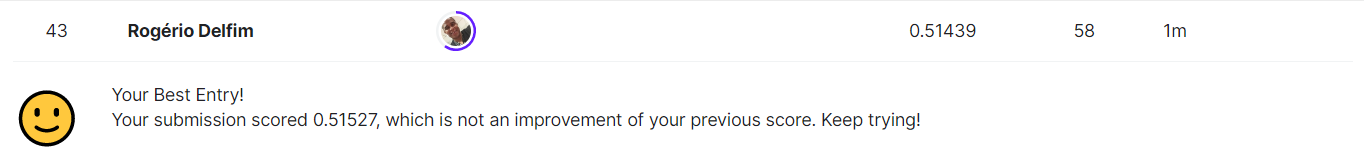

## 5.1. Distribuição e calibração

In [76]:
df_pred_tr_n3.columns

Index(['rforest_0.52295_seed_12359', 'fold', 'rforest_0.52183_seed_12359',
       'fold', 'xgb_0.55468_seed_12359', 'fold', 'lgbm_0.52346_seed_12359',
       'fold', 'hboosting_0.52406_seed_12359', 'fold', 'lr_0.52693_seed_12359',
       'fold'],
      dtype='object')

KeyError: 'fold'

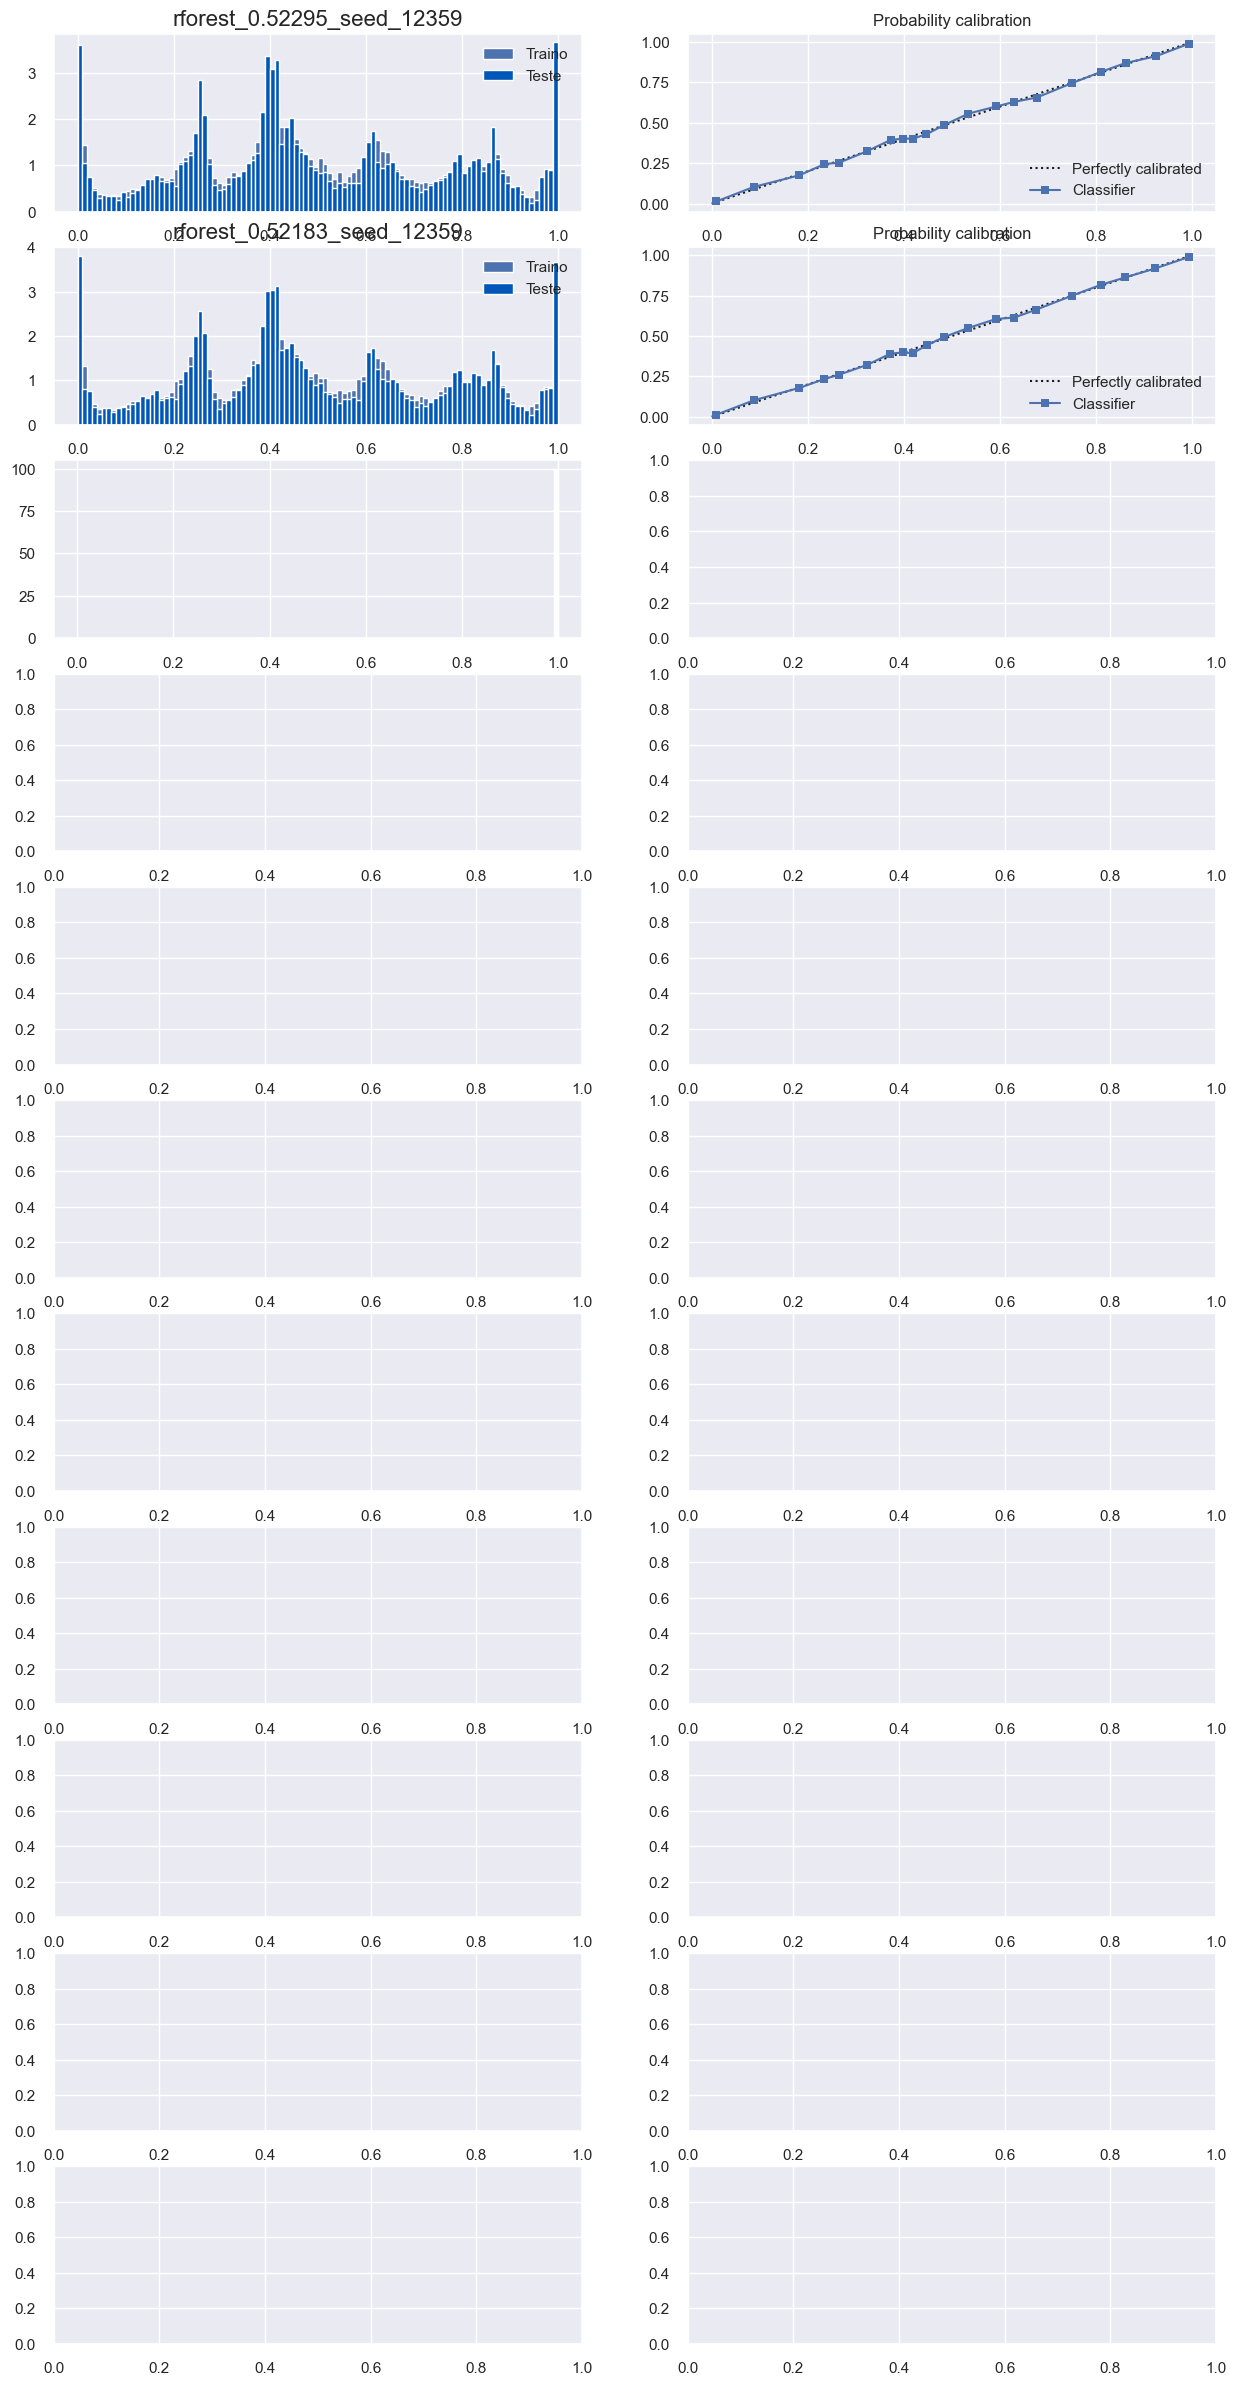

In [77]:
cols = df_pred_tr_n3.columns.to_list()
cols.remove('fold')
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 30)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr_n3[col], range=(0, 1), bins=100, density=True, label='Traino') # color='#ffd700'
    axs[i][0].hist(df_pred_ts_n3[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr_n3[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

In [ ]:
plt.figure(figsize=(9,5))
_ = df_pred_tr_n3.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman')

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Observamos que a distribuição dos datasets(treino/teste) seguem a mesma distribuição, porém com a maioria das probabilidade entre 0.2 e 0.8, ainda temos um espaço para melhoria. Em relação a calibração a maioria dos modelos tem uma boa calibragem, exceto LR e XGB. <p>


</div> 

In [ ]:
cols_n3 = ['RForest', 'XGB', 'LGBM', 'HBoosting', 'LR' ] 
df_pred_tr_n3.columns= cols_n3
df_pred_ts_n3.columns= cols_n3
df_pred_ts_n3.head()
 
#cols_new = ['LR','KNN','MLP','XGB','ExTrees','LGBM','RForest',
#            'HBoosting','KNN_100','KNN_50','MLP_2']

In [ ]:
w1 = .7
w2 = .3
name = 'nb_02_n4_19_emsable_average_RForest_LGBM_w1_{}_w2_{}.csv'.format(w1, w2)
name = 'nb_02_n4_22_emsable_average.csv'
df_submission['pred'] = df_pred_ts_n3['RForest']*w1 + df_pred_ts_n3['HBoosting']*w2
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51404 - nb_02_n4_22_emsable_average.csv

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 6. CONCLUSÃO </h1>    
</div>

<div class="alert alert-block alert-info" style="border-radius:15px">

Com esse notebook, consegui superar o score do notebook anterior, podemos destacar os seguintes pontos: <br>
    
- A remoção das variáveis irrelevantes com a utilização do <b>SelectFromModel do sklearn</b> deve efeito relevante para as previsões;
    
- As duas variáveis (PCA e cluster) criadas também ajudaram significativamente na melhoria do score;
    
- Foram criadas variáveis estatísca, mas não teve bom desempenho, sendo removido;  
        
- Foram geradas diversas previsões no segundo nível, no terceiro nível foi utilizado as previsões do segundo nível com a utilização de alguns classificadores do segundo nível, o melhor modelo fo <b>R. Forest</b>.  
   
<p style="color: black; font-family: Arial Black">PRÓXIMOS PASSOS:</p> <br>
- Ajuste de parametros; 
- Seleção de variáveis com permutação;
    
</div>